# Optuna Tuning | RandomForestClassifier
**RandomForestClassifier** hyper-parameter tuning for the [UCI dataset](https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008). The dataset represents ten years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks.

> **[CAUTION]** Do <u>NOT</u> execute "Run All", that will tell Optuna to run hyper-parameter tuning, regardless of whether you have already done it or not. Avoid running the _"Hyper-parameter tuning"_ subsections if you don't have to.

## **0. Initial Setup**
Taking care of package imports, defining work constants, and loading all necessary datasets.

### 0.1 Python imports

In [1]:
# Data Analysis
import numpy as np
import pandas as pd

# Hyperparameter optimization
import optuna

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Visualization configurations
pd.set_option('display.max_columns', 60)
plt.style.use('ggplot')
sns.set_style('white')

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from collections import Counter

from imblearn.combine import SMOTETomek
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks

from optuna.storages import JournalStorage
from optuna.storages.journal import JournalFileBackend

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, fbeta_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler

### 0.2 Constants

In [3]:
DATA_PATH = '../data/original/'
DATA_PATH_PROCESSED = '../data/processed/'

MODEL_NAME = 'rf' # Modify this to the model you are using

OPTUNA_PATH = '../optuna/'
OPTUNA_DIR = OPTUNA_PATH + MODEL_NAME + '/'

STUDY_NAME = "Diabetes_130-US"
STUDY_PATH_NONE = OPTUNA_DIR + f"optuna_{MODEL_NAME}_none.log"
STUDY_PATH_RUS = OPTUNA_DIR + f"optuna_{MODEL_NAME}_rus.log"
STUDY_PATH_SMOTE = OPTUNA_DIR + f"optuna_{MODEL_NAME}_smote.log"
STUDY_PATH_SMOTE_TOMEK = OPTUNA_DIR + f"optuna_{MODEL_NAME}_smote-tomek.log"

SCORING = 'f1_macro'
N_TRIALS = 100
RANDOM_STATE = 38

### 0.3 Loading datasets

In [4]:
train_set = pd.read_csv(
    DATA_PATH_PROCESSED + 'train.csv',
    na_values='?',
    keep_default_na=False
)

test_set = pd.read_csv(
    DATA_PATH_PROCESSED + 'test.csv',
    na_values='?',
    keep_default_na=False
)

## **1. Feature Scaling**
Applying scaling to numerical features.

In [5]:
target = 'readmitted'

X_train = train_set.drop(target, axis=1)
y_train = train_set[target]

X_test = test_set.drop(target, axis=1)
y_test = test_set[target]

### 1.1 Scaling
Applying scaling to numerical features, while leaving boolean features untouched.

In [6]:
NUMERICAL_COLUMNS = [
    'time_in_hospital', 'age', 'num_lab_procedures',
    'num_diagnoses', 'num_inpatient'
]

In [7]:
scaler = StandardScaler()

X_train[NUMERICAL_COLUMNS] = scaler.fit_transform(X_train[NUMERICAL_COLUMNS])
X_test[NUMERICAL_COLUMNS] = scaler.transform(X_test[NUMERICAL_COLUMNS])

In [8]:
print('Train set:', Counter(y_train))
print('Test set:', Counter(y_test))

Train set: Counter({0: 37607, 1: 4441})
Test set: Counter({0: 16117, 1: 1904})


## **2. Optuna Hyper-parameter Tuning | No under/oversampling**
Hyper-parameter tuning of the model using Optuna, with no undersampling/oversampling.

### 2.1 Objective & study setup
Preparing the objective function with all hyper-parameters, and creating/loading the Optuna study.

In [9]:
def objective(trial: optuna.Trial) -> float:
    # Hyperparameter search space
    params = {
        "n_estimators": 100,
        "max_depth": trial.suggest_int("max_depth", 4, 30, step=2),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 60, step=2)
    }
    
    # Define validation folds
    kf = StratifiedKFold(n_splits=5, shuffle=False)
    model = RandomForestClassifier(**params, random_state=RANDOM_STATE)
    
    # Cross validation
    f1_score = cross_val_score(model, X_train, y_train, cv=kf, scoring=SCORING)

    print("Cross validation F1-scores: {}".format(f1_score))
    print("Average F1-score: {}".format(f1_score.mean()))

    return f1_score.mean()

In [10]:
# Set up study with name and storage
storage = JournalStorage(JournalFileBackend(STUDY_PATH_NONE))

study = optuna.create_study(
    direction="maximize",
    study_name=STUDY_NAME,
    storage=storage,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(constant_liar=True, seed=RANDOM_STATE),
    pruner=optuna.pruners.SuccessiveHalvingPruner()
)

optuna.logging.set_verbosity(optuna.logging.INFO)

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2024-12-29 18:13:32,309] A new study created in Journal with name: Diabetes_130-US


### 2.2 Hyper-parameter tuning
**(CAUTION)** <u>Do not run</u>, unless you already need to find the best parameters. If you already have bound the best model configuration, <u>run the section above</u> _(Objective & study setup)_.

In [11]:
study.optimize(
    objective,
    n_trials=N_TRIALS,
    n_jobs=-1 # Use all available cores
)

[I 2024-12-29 18:13:39,661] Trial 11 finished with value: 0.47212353264706886 and parameters: {'max_depth': 4, 'min_samples_leaf': 56}. Best is trial 11 with value: 0.47212353264706886.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-29 18:13:40,691] Trial 5 finished with value: 0.47212353264706886 and parameters: {'max_depth': 6, 'min_samples_leaf': 8}. Best is trial 5 with value: 0.47212353264706886.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-29 18:13:42,895] Trial 6 finished with value: 0.47212353264706886 and parameters: {'max_depth': 14, 'min_samples_leaf': 52}. Best is trial 5 with value: 0.47212353264706886.
[I 2024-12-29 18:13:42,915] Trial 1 finished with value: 0.47212353264706886 and parameters: {'max_depth': 30, 'min_samples_leaf': 52}. Best is trial 1 with value: 0.47212353264706886.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886
Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-29 18:13:43,324] Trial 2 finished with value: 0.47212353264706886 and parameters: {'max_depth': 30, 'min_samples_leaf': 40}. Best is trial 1 with value: 0.47212353264706886.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-29 18:13:43,768] Trial 9 finished with value: 0.47212353264706886 and parameters: {'max_depth': 18, 'min_samples_leaf': 28}. Best is trial 1 with value: 0.47212353264706886.
[I 2024-12-29 18:13:43,934] Trial 8 finished with value: 0.47212353264706886 and parameters: {'max_depth': 12, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.47212353264706886.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886
Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-29 18:13:44,060] Trial 10 finished with value: 0.47212353264706886 and parameters: {'max_depth': 18, 'min_samples_leaf': 26}. Best is trial 1 with value: 0.47212353264706886.
[I 2024-12-29 18:13:44,191] Trial 0 finished with value: 0.47212353264706886 and parameters: {'max_depth': 30, 'min_samples_leaf': 20}. Best is trial 0 with value: 0.47212353264706886.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886
Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-29 18:13:44,997] Trial 3 finished with value: 0.47212353264706886 and parameters: {'max_depth': 16, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.47212353264706886.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-29 18:13:45,994] Trial 4 finished with value: 0.47212353264706886 and parameters: {'max_depth': 24, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.47212353264706886.
[I 2024-12-29 18:13:46,083] Trial 7 finished with value: 0.4725781979737643 and parameters: {'max_depth': 30, 'min_samples_leaf': 6}. Best is trial 7 with value: 0.4725781979737643.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886
Cross validation F1-scores: [0.47328605 0.47213156 0.47321726 0.47212806 0.47212806]
Average F1-score: 0.4725781979737643


[I 2024-12-29 18:13:50,716] Trial 13 finished with value: 0.47212353264706886 and parameters: {'max_depth': 10, 'min_samples_leaf': 52}. Best is trial 7 with value: 0.4725781979737643.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-29 18:13:50,933] Trial 12 finished with value: 0.47212353264706886 and parameters: {'max_depth': 14, 'min_samples_leaf': 24}. Best is trial 7 with value: 0.4725781979737643.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-29 18:13:51,572] Trial 20 finished with value: 0.47212353264706886 and parameters: {'max_depth': 4, 'min_samples_leaf': 54}. Best is trial 7 with value: 0.4725781979737643.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-29 18:13:53,049] Trial 17 finished with value: 0.47212353264706886 and parameters: {'max_depth': 8, 'min_samples_leaf': 22}. Best is trial 7 with value: 0.4725781979737643.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-29 18:13:53,306] Trial 18 finished with value: 0.47212353264706886 and parameters: {'max_depth': 8, 'min_samples_leaf': 20}. Best is trial 7 with value: 0.4725781979737643.
[I 2024-12-29 18:13:53,401] Trial 15 finished with value: 0.47212353264706886 and parameters: {'max_depth': 16, 'min_samples_leaf': 56}. Best is trial 7 with value: 0.4725781979737643.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886
Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-29 18:13:54,746] Trial 14 finished with value: 0.47212353264706886 and parameters: {'max_depth': 24, 'min_samples_leaf': 20}. Best is trial 7 with value: 0.4725781979737643.
[I 2024-12-29 18:13:54,785] Trial 16 finished with value: 0.47212353264706886 and parameters: {'max_depth': 20, 'min_samples_leaf': 28}. Best is trial 7 with value: 0.4725781979737643.
[I 2024-12-29 18:13:54,825] Trial 19 finished with value: 0.47212353264706886 and parameters: {'max_depth': 22, 'min_samples_leaf': 48}. Best is trial 7 with value: 0.4725781979737643.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886
Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886
Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-29 18:13:56,223] Trial 21 finished with value: 0.47212353264706886 and parameters: {'max_depth': 26, 'min_samples_leaf': 36}. Best is trial 7 with value: 0.4725781979737643.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-29 18:13:56,949] Trial 22 finished with value: 0.47212353264706886 and parameters: {'max_depth': 28, 'min_samples_leaf': 44}. Best is trial 7 with value: 0.4725781979737643.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-29 18:13:58,506] Trial 23 finished with value: 0.47212353264706886 and parameters: {'max_depth': 28, 'min_samples_leaf': 14}. Best is trial 7 with value: 0.4725781979737643.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-29 18:14:02,997] Trial 24 finished with value: 0.47212353264706886 and parameters: {'max_depth': 26, 'min_samples_leaf': 14}. Best is trial 7 with value: 0.4725781979737643.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-29 18:14:03,587] Trial 26 finished with value: 0.47212353264706886 and parameters: {'max_depth': 30, 'min_samples_leaf': 16}. Best is trial 7 with value: 0.4725781979737643.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-29 18:14:03,861] Trial 29 finished with value: 0.47212353264706886 and parameters: {'max_depth': 30, 'min_samples_leaf': 60}. Best is trial 7 with value: 0.4725781979737643.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-29 18:14:04,190] Trial 27 finished with value: 0.47212353264706886 and parameters: {'max_depth': 26, 'min_samples_leaf': 34}. Best is trial 7 with value: 0.4725781979737643.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-29 18:14:05,674] Trial 31 finished with value: 0.47212353264706886 and parameters: {'max_depth': 20, 'min_samples_leaf': 42}. Best is trial 7 with value: 0.4725781979737643.
[I 2024-12-29 18:14:05,844] Trial 25 finished with value: 0.47327790302728784 and parameters: {'max_depth': 22, 'min_samples_leaf': 2}. Best is trial 25 with value: 0.47327790302728784.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886
Cross validation F1-scores: [0.47397459 0.47287318 0.47287318 0.47397104 0.47269752]
Average F1-score: 0.47327790302728784


[I 2024-12-29 18:14:05,890] Trial 32 finished with value: 0.47212353264706886 and parameters: {'max_depth': 30, 'min_samples_leaf': 36}. Best is trial 25 with value: 0.47327790302728784.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-29 18:14:07,214] Trial 30 finished with value: 0.47212353264706886 and parameters: {'max_depth': 22, 'min_samples_leaf': 16}. Best is trial 25 with value: 0.47327790302728784.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-29 18:14:08,392] Trial 28 finished with value: 0.472405099090745 and parameters: {'max_depth': 28, 'min_samples_leaf': 2}. Best is trial 25 with value: 0.47327790302728784.


Cross validation F1-scores: [0.47259782 0.47273551 0.47263224 0.47262866 0.47143127]
Average F1-score: 0.472405099090745


[I 2024-12-29 18:14:08,842] Trial 33 finished with value: 0.47212353264706886 and parameters: {'max_depth': 28, 'min_samples_leaf': 12}. Best is trial 25 with value: 0.47327790302728784.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-29 18:14:09,556] Trial 35 finished with value: 0.47212353264706886 and parameters: {'max_depth': 26, 'min_samples_leaf': 32}. Best is trial 25 with value: 0.47327790302728784.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-29 18:14:10,225] Trial 34 finished with value: 0.47212353264706886 and parameters: {'max_depth': 24, 'min_samples_leaf': 6}. Best is trial 25 with value: 0.47327790302728784.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-29 18:14:13,747] Trial 36 finished with value: 0.47212353264706886 and parameters: {'max_depth': 30, 'min_samples_leaf': 40}. Best is trial 25 with value: 0.47327790302728784.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-29 18:14:14,173] Trial 37 finished with value: 0.47212353264706886 and parameters: {'max_depth': 28, 'min_samples_leaf': 46}. Best is trial 25 with value: 0.47327790302728784.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-29 18:14:15,969] Trial 39 finished with value: 0.47212353264706886 and parameters: {'max_depth': 30, 'min_samples_leaf': 18}. Best is trial 25 with value: 0.47327790302728784.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-29 18:14:16,694] Trial 40 finished with value: 0.47212353264706886 and parameters: {'max_depth': 20, 'min_samples_leaf': 28}. Best is trial 25 with value: 0.47327790302728784.
[I 2024-12-29 18:14:16,724] Trial 38 finished with value: 0.47212353264706886 and parameters: {'max_depth': 24, 'min_samples_leaf': 8}. Best is trial 25 with value: 0.47327790302728784.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886
Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-29 18:14:18,262] Trial 42 finished with value: 0.4728022174712427 and parameters: {'max_depth': 14, 'min_samples_leaf': 4}. Best is trial 25 with value: 0.47327790302728784.


Cross validation F1-scores: [0.47328605 0.47213156 0.47318285 0.47328256 0.47212806]
Average F1-score: 0.4728022174712427


[I 2024-12-29 18:14:19,776] Trial 43 finished with value: 0.47212353264706886 and parameters: {'max_depth': 24, 'min_samples_leaf': 10}. Best is trial 25 with value: 0.47327790302728784.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-29 18:14:20,826] Trial 41 finished with value: 0.47327790302728784 and parameters: {'max_depth': 22, 'min_samples_leaf': 2}. Best is trial 25 with value: 0.47327790302728784.


Cross validation F1-scores: [0.47397459 0.47287318 0.47287318 0.47397104 0.47269752]
Average F1-score: 0.47327790302728784


[I 2024-12-29 18:14:21,697] Trial 44 finished with value: 0.4725781979737643 and parameters: {'max_depth': 28, 'min_samples_leaf': 6}. Best is trial 25 with value: 0.47327790302728784.


Cross validation F1-scores: [0.47328605 0.47213156 0.47321726 0.47212806 0.47212806]
Average F1-score: 0.4725781979737643


[I 2024-12-29 18:14:22,192] Trial 46 finished with value: 0.47212353264706886 and parameters: {'max_depth': 28, 'min_samples_leaf': 10}. Best is trial 25 with value: 0.47327790302728784.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-29 18:14:23,997] Trial 45 finished with value: 0.4721926752101145 and parameters: {'max_depth': 26, 'min_samples_leaf': 2}. Best is trial 25 with value: 0.47327790302728784.


Cross validation F1-scores: [0.47266667 0.47273551 0.47136841 0.47262866 0.47156413]
Average F1-score: 0.4721926752101145


[I 2024-12-29 18:14:24,577] Trial 47 finished with value: 0.47313841237888116 and parameters: {'max_depth': 18, 'min_samples_leaf': 2}. Best is trial 25 with value: 0.47327790302728784.


Cross validation F1-scores: [0.47418846 0.47206529 0.47318285 0.47317935 0.47307612]
Average F1-score: 0.47313841237888116


[I 2024-12-29 18:14:26,849] Trial 49 finished with value: 0.47212353264706886 and parameters: {'max_depth': 26, 'min_samples_leaf': 10}. Best is trial 25 with value: 0.47327790302728784.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-29 18:14:27,502] Trial 50 finished with value: 0.47212353264706886 and parameters: {'max_depth': 30, 'min_samples_leaf': 24}. Best is trial 25 with value: 0.47327790302728784.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-29 18:14:27,882] Trial 48 finished with value: 0.472572076771179 and parameters: {'max_depth': 22, 'min_samples_leaf': 4}. Best is trial 25 with value: 0.47327790302728784.


Cross validation F1-scores: [0.47328605 0.47209842 0.47209842 0.47328256 0.47209492]
Average F1-score: 0.472572076771179


[I 2024-12-29 18:14:29,701] Trial 52 finished with value: 0.47212353264706886 and parameters: {'max_depth': 30, 'min_samples_leaf': 8}. Best is trial 25 with value: 0.47327790302728784.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-29 18:14:30,281] Trial 51 finished with value: 0.4725781979737643 and parameters: {'max_depth': 28, 'min_samples_leaf': 6}. Best is trial 25 with value: 0.47327790302728784.


Cross validation F1-scores: [0.47328605 0.47213156 0.47321726 0.47212806 0.47212806]
Average F1-score: 0.4725781979737643


[I 2024-12-29 18:14:31,529] Trial 53 finished with value: 0.47258533151549786 and parameters: {'max_depth': 16, 'min_samples_leaf': 4}. Best is trial 25 with value: 0.47327790302728784.


Cross validation F1-scores: [0.47328605 0.47213156 0.47209842 0.47328256 0.47212806]
Average F1-score: 0.47258533151549786


[I 2024-12-29 18:14:32,311] Trial 54 finished with value: 0.4728022174712427 and parameters: {'max_depth': 14, 'min_samples_leaf': 4}. Best is trial 25 with value: 0.47327790302728784.


Cross validation F1-scores: [0.47328605 0.47213156 0.47318285 0.47328256 0.47212806]
Average F1-score: 0.4728022174712427


[I 2024-12-29 18:14:32,616] Trial 55 finished with value: 0.4727820826268273 and parameters: {'max_depth': 12, 'min_samples_leaf': 2}. Best is trial 25 with value: 0.47327790302728784.


Cross validation F1-scores: [0.47325166 0.47209842 0.47321726 0.47324816 0.47209492]
Average F1-score: 0.4727820826268273


[I 2024-12-29 18:14:33,564] Trial 57 finished with value: 0.47235443173114716 and parameters: {'max_depth': 12, 'min_samples_leaf': 6}. Best is trial 25 with value: 0.47327790302728784.


Cross validation F1-scores: [0.47328605 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47235443173114716


[I 2024-12-29 18:14:34,187] Trial 56 finished with value: 0.47212353264706886 and parameters: {'max_depth': 18, 'min_samples_leaf': 12}. Best is trial 25 with value: 0.47327790302728784.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-29 18:14:35,628] Trial 58 finished with value: 0.47212353264706886 and parameters: {'max_depth': 14, 'min_samples_leaf': 12}. Best is trial 25 with value: 0.47327790302728784.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-29 18:14:38,803] Trial 59 finished with value: 0.47313841237888116 and parameters: {'max_depth': 18, 'min_samples_leaf': 2}. Best is trial 25 with value: 0.47327790302728784.


Cross validation F1-scores: [0.47418846 0.47206529 0.47318285 0.47317935 0.47307612]
Average F1-score: 0.47313841237888116


[I 2024-12-29 18:14:39,923] Trial 63 finished with value: 0.4723478046652483 and parameters: {'max_depth': 10, 'min_samples_leaf': 2}. Best is trial 25 with value: 0.47327790302728784.
[I 2024-12-29 18:14:39,961] Trial 61 finished with value: 0.47212353264706886 and parameters: {'max_depth': 16, 'min_samples_leaf': 8}. Best is trial 25 with value: 0.47327790302728784.


Cross validation F1-scores: [0.47213156 0.47213156 0.47206529 0.47328256 0.47212806]
Average F1-score: 0.4723478046652483
Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-29 18:14:40,524] Trial 60 finished with value: 0.47258533151549786 and parameters: {'max_depth': 20, 'min_samples_leaf': 4}. Best is trial 25 with value: 0.47327790302728784.


Cross validation F1-scores: [0.47328605 0.47213156 0.47209842 0.47328256 0.47212806]
Average F1-score: 0.47258533151549786


[I 2024-12-29 18:14:41,109] Trial 62 finished with value: 0.47258533151549786 and parameters: {'max_depth': 22, 'min_samples_leaf': 6}. Best is trial 25 with value: 0.47327790302728784.


Cross validation F1-scores: [0.47328605 0.47213156 0.47209842 0.47328256 0.47212806]
Average F1-score: 0.47258533151549786


[I 2024-12-29 18:14:42,332] Trial 66 finished with value: 0.47212353264706886 and parameters: {'max_depth': 10, 'min_samples_leaf': 4}. Best is trial 25 with value: 0.47327790302728784.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-29 18:14:43,223] Trial 65 finished with value: 0.47212353264706886 and parameters: {'max_depth': 16, 'min_samples_leaf': 14}. Best is trial 25 with value: 0.47327790302728784.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-29 18:14:43,735] Trial 64 finished with value: 0.4725781986740367 and parameters: {'max_depth': 18, 'min_samples_leaf': 4}. Best is trial 25 with value: 0.47327790302728784.
[I 2024-12-29 18:14:43,866] Trial 67 finished with value: 0.4727820826268273 and parameters: {'max_depth': 12, 'min_samples_leaf': 2}. Best is trial 25 with value: 0.47327790302728784.


Cross validation F1-scores: [0.47213156 0.47213156 0.47321726 0.47328256 0.47212806]
Average F1-score: 0.4725781986740367
Cross validation F1-scores: [0.47325166 0.47209842 0.47321726 0.47324816 0.47209492]
Average F1-score: 0.4727820826268273


[I 2024-12-29 18:14:44,370] Trial 70 finished with value: 0.47212353264706886 and parameters: {'max_depth': 8, 'min_samples_leaf': 10}. Best is trial 25 with value: 0.47327790302728784.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-29 18:14:45,348] Trial 68 finished with value: 0.47212353264706886 and parameters: {'max_depth': 14, 'min_samples_leaf': 8}. Best is trial 25 with value: 0.47327790302728784.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-29 18:14:46,527] Trial 69 finished with value: 0.4725045329771205 and parameters: {'max_depth': 14, 'min_samples_leaf': 2}. Best is trial 25 with value: 0.47327790302728784.


Cross validation F1-scores: [0.47318285 0.471999   0.47206529 0.47321375 0.47206178]
Average F1-score: 0.4725045329771205


[I 2024-12-29 18:14:51,071] Trial 72 finished with value: 0.4727820826268273 and parameters: {'max_depth': 12, 'min_samples_leaf': 2}. Best is trial 25 with value: 0.47327790302728784.
[I 2024-12-29 18:14:51,157] Trial 73 finished with value: 0.4727820826268273 and parameters: {'max_depth': 12, 'min_samples_leaf': 2}. Best is trial 25 with value: 0.47327790302728784.


Cross validation F1-scores: [0.47325166 0.47209842 0.47321726 0.47324816 0.47209492]
Average F1-score: 0.4727820826268273
Cross validation F1-scores: [0.47325166 0.47209842 0.47321726 0.47324816 0.47209492]
Average F1-score: 0.4727820826268273


[I 2024-12-29 18:14:52,089] Trial 71 finished with value: 0.4725781986740367 and parameters: {'max_depth': 18, 'min_samples_leaf': 4}. Best is trial 25 with value: 0.47327790302728784.


Cross validation F1-scores: [0.47213156 0.47213156 0.47321726 0.47328256 0.47212806]
Average F1-score: 0.4725781986740367


[I 2024-12-29 18:14:53,037] Trial 75 finished with value: 0.4728022174712427 and parameters: {'max_depth': 14, 'min_samples_leaf': 4}. Best is trial 25 with value: 0.47327790302728784.


Cross validation F1-scores: [0.47328605 0.47213156 0.47318285 0.47328256 0.47212806]
Average F1-score: 0.4728022174712427


[I 2024-12-29 18:14:53,358] Trial 74 finished with value: 0.47235443243141956 and parameters: {'max_depth': 20, 'min_samples_leaf': 6}. Best is trial 25 with value: 0.47327790302728784.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47328256 0.47212806]
Average F1-score: 0.47235443243141956


[I 2024-12-29 18:14:53,676] Trial 79 finished with value: 0.47212353264706886 and parameters: {'max_depth': 10, 'min_samples_leaf': 12}. Best is trial 25 with value: 0.47327790302728784.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-29 18:14:54,456] Trial 76 finished with value: 0.47212353264706886 and parameters: {'max_depth': 16, 'min_samples_leaf': 8}. Best is trial 25 with value: 0.47327790302728784.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-29 18:14:56,095] Trial 78 finished with value: 0.47212353264706886 and parameters: {'max_depth': 18, 'min_samples_leaf': 8}. Best is trial 25 with value: 0.47327790302728784.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-29 18:14:57,114] Trial 81 finished with value: 0.47212353264706886 and parameters: {'max_depth': 14, 'min_samples_leaf': 6}. Best is trial 25 with value: 0.47327790302728784.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-29 18:14:57,620] Trial 82 finished with value: 0.4727820826268273 and parameters: {'max_depth': 12, 'min_samples_leaf': 2}. Best is trial 25 with value: 0.47327790302728784.
[I 2024-12-29 18:14:57,620] Trial 77 finished with value: 0.47327790302728784 and parameters: {'max_depth': 22, 'min_samples_leaf': 2}. Best is trial 25 with value: 0.47327790302728784.
[I 2024-12-29 18:14:57,800] Trial 80 finished with value: 0.47258533151549786 and parameters: {'max_depth': 20, 'min_samples_leaf': 4}. Best is trial 25 with value: 0.47327790302728784.


Cross validation F1-scores: [0.47325166 0.47209842 0.47321726 0.47324816 0.47209492]
Average F1-score: 0.4727820826268273
Cross validation F1-scores: [0.47397459 0.47287318 0.47287318 0.47397104 0.47269752]
Average F1-score: 0.47327790302728784
Cross validation F1-scores: [0.47328605 0.47213156 0.47209842 0.47328256 0.47212806]
Average F1-score: 0.47258533151549786


[I 2024-12-29 18:15:00,971] Trial 84 finished with value: 0.47212353264706886 and parameters: {'max_depth': 10, 'min_samples_leaf': 6}. Best is trial 25 with value: 0.47327790302728784.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-29 18:15:03,042] Trial 85 finished with value: 0.472809349968105 and parameters: {'max_depth': 12, 'min_samples_leaf': 4}. Best is trial 25 with value: 0.47327790302728784.


Cross validation F1-scores: [0.47328605 0.47213156 0.47325166 0.47328256 0.47209492]
Average F1-score: 0.472809349968105


[I 2024-12-29 18:15:04,366] Trial 83 finished with value: 0.47291689707304874 and parameters: {'max_depth': 16, 'min_samples_leaf': 2}. Best is trial 25 with value: 0.47327790302728784.
[I 2024-12-29 18:15:04,416] Trial 86 finished with value: 0.47212353264706886 and parameters: {'max_depth': 14, 'min_samples_leaf': 10}. Best is trial 25 with value: 0.47327790302728784.


Cross validation F1-scores: [0.47301083 0.47206529 0.47325166 0.47432755 0.47192916]
Average F1-score: 0.47291689707304874
Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-29 18:15:05,312] Trial 87 finished with value: 0.4728022174712427 and parameters: {'max_depth': 14, 'min_samples_leaf': 4}. Best is trial 25 with value: 0.47327790302728784.


Cross validation F1-scores: [0.47328605 0.47213156 0.47318285 0.47328256 0.47212806]
Average F1-score: 0.4728022174712427


[I 2024-12-29 18:15:05,782] Trial 88 finished with value: 0.47212353264706886 and parameters: {'max_depth': 16, 'min_samples_leaf': 8}. Best is trial 25 with value: 0.47327790302728784.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-29 18:15:07,671] Trial 89 finished with value: 0.47258533151549786 and parameters: {'max_depth': 20, 'min_samples_leaf': 4}. Best is trial 25 with value: 0.47327790302728784.


Cross validation F1-scores: [0.47328605 0.47213156 0.47209842 0.47328256 0.47212806]
Average F1-score: 0.47258533151549786


[I 2024-12-29 18:15:08,316] Trial 91 finished with value: 0.47212353264706886 and parameters: {'max_depth': 22, 'min_samples_leaf': 14}. Best is trial 25 with value: 0.47327790302728784.
[I 2024-12-29 18:15:08,376] Trial 90 finished with value: 0.47212353264706886 and parameters: {'max_depth': 18, 'min_samples_leaf': 6}. Best is trial 25 with value: 0.47327790302728784.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886
Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-29 18:15:10,049] Trial 94 finished with value: 0.47258533151549786 and parameters: {'max_depth': 24, 'min_samples_leaf': 4}. Best is trial 25 with value: 0.47327790302728784.


Cross validation F1-scores: [0.47328605 0.47213156 0.47209842 0.47328256 0.47212806]
Average F1-score: 0.47258533151549786


[I 2024-12-29 18:15:10,923] Trial 93 finished with value: 0.47327790302728784 and parameters: {'max_depth': 22, 'min_samples_leaf': 2}. Best is trial 25 with value: 0.47327790302728784.
[I 2024-12-29 18:15:11,047] Trial 92 finished with value: 0.47327790302728784 and parameters: {'max_depth': 22, 'min_samples_leaf': 2}. Best is trial 25 with value: 0.47327790302728784.


Cross validation F1-scores: [0.47397459 0.47287318 0.47287318 0.47397104 0.47269752]
Average F1-score: 0.47327790302728784
Cross validation F1-scores: [0.47397459 0.47287318 0.47287318 0.47397104 0.47269752]
Average F1-score: 0.47327790302728784


[I 2024-12-29 18:15:11,552] Trial 95 finished with value: 0.47212353264706886 and parameters: {'max_depth': 18, 'min_samples_leaf': 6}. Best is trial 25 with value: 0.47327790302728784.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-29 18:15:13,212] Trial 98 finished with value: 0.47212353264706886 and parameters: {'max_depth': 20, 'min_samples_leaf': 10}. Best is trial 25 with value: 0.47327790302728784.
[I 2024-12-29 18:15:13,298] Trial 99 finished with value: 0.47212353264706886 and parameters: {'max_depth': 18, 'min_samples_leaf': 16}. Best is trial 25 with value: 0.47327790302728784.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886
Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-29 18:15:13,521] Trial 96 finished with value: 0.47258533151549786 and parameters: {'max_depth': 24, 'min_samples_leaf': 4}. Best is trial 25 with value: 0.47327790302728784.


Cross validation F1-scores: [0.47328605 0.47213156 0.47209842 0.47328256 0.47212806]
Average F1-score: 0.47258533151549786


[I 2024-12-29 18:15:13,929] Trial 97 finished with value: 0.47291689707304874 and parameters: {'max_depth': 16, 'min_samples_leaf': 2}. Best is trial 25 with value: 0.47327790302728784.


Cross validation F1-scores: [0.47301083 0.47206529 0.47325166 0.47432755 0.47192916]
Average F1-score: 0.47291689707304874


In [12]:
print('Best Trial: {}'.format(study.best_trial.number))
print('Best Parameters: {}'.format(study.best_params))
print('Best Value: {}'.format(study.best_value))

Best Trial: 25
Best Parameters: {'max_depth': 22, 'min_samples_leaf': 2}
Best Value: 0.47327790302728784


### 2.3 Optuna Visualizations
Visualizing hyper-parameter tuning results obtained by running Optuna.

In [13]:
optuna.visualization.plot_optimization_history(study)

In [14]:
optuna.visualization.plot_slice(study)

In [15]:
optuna.visualization.plot_param_importances(study)

In [16]:
optuna.visualization.plot_parallel_coordinate(study)

In [17]:
optuna.visualization.plot_contour(study)

In [18]:
optuna.visualization.plot_timeline(study)

### 2.4 Fitting Best Model
Fitting the final model using the best hyper-parameters found by Optuna.

In [19]:
# Fit best model on the training set
best_params = study.best_params

model = RandomForestClassifier(**best_params, random_state=RANDOM_STATE)

model.fit(X_train, y_train)

RandomForestClassifier(max_depth=22, min_samples_leaf=2, random_state=38)

In [20]:
# Predictions
y_train_pred_none = model.predict(X_train)
y_test_pred_none = model.predict(X_test)

In [21]:
ac_train_none = accuracy_score(y_train, y_train_pred_none)
ac_test_none = accuracy_score(y_test, y_test_pred_none)

print('Train accuracy: ', ac_train_none)
print('Test accuracy: ', ac_test_none)

Train accuracy:  0.9037766362252664
Test accuracy:  0.8932911603129682


In [22]:
# Visualize precision, recall, F1-score
print(classification_report(
    y_test, y_test_pred_none,
    target_names=['Late or non-readmission', 'Early-readmission']
))

                         precision    recall  f1-score   support

Late or non-readmission       0.89      1.00      0.94     16117
      Early-readmission       0.15      0.00      0.00      1904

               accuracy                           0.89     18021
              macro avg       0.52      0.50      0.47     18021
           weighted avg       0.82      0.89      0.84     18021



In [23]:
# Compute precision, recall, F1-score, ROC-AUC-score, and accuracy
recall_none = recall_score(y_test, y_test_pred_none, average='macro')
precision_none = precision_score(y_test, y_test_pred_none, average='macro')
f1_none = f1_score(y_test, y_test_pred_none, average='macro')
roc_auc_none = roc_auc_score(y_test, y_test_pred_none, average='macro')
accuracy_none = accuracy_score(y_test, y_test_pred_none)

<Axes: >

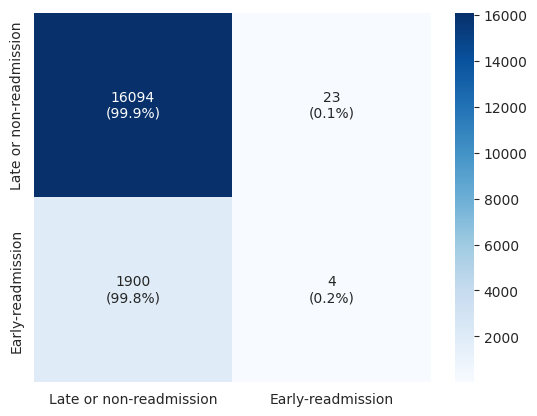

In [24]:
# Visualize confusion matrix with both absolute and percentage values
cm_none = confusion_matrix(y_test, y_test_pred_none)
cm_none_norm = confusion_matrix(y_test, y_test_pred_none, normalize='true')

annotations_none = np.array([
    [f"{val}\n({perc:.1%})" for val, perc in zip(row, norm_row)]
    for row, norm_row in zip(cm_none, cm_none_norm)
])

sns.heatmap(
    cm_none,
    annot=annotations_none,
    cmap='Blues',
    fmt='',
    xticklabels=['Late or non-readmission', 'Early-readmission'],
    yticklabels=['Late or non-readmission', 'Early-readmission']
)

## **3. Optuna Hyper-parameter Tuning | Undersampling**
Hyper-parameter tuning of the model using Optuna, and undersampling with RandomUnderSampler.

### 3.1 Objective & study setup
Preparing the objective function with all hyper-parameters, and creating/loading the Optuna study.

In [25]:
def objective(trial: optuna.Trial) -> float:
    # Hyperparameter search space
    params = {
        "n_estimators": 100,
        "max_depth": trial.suggest_int("max_depth", 4, 30, step=2),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 60, step=2)
    }
    
    # Build pipeline
    pipeline = make_pipeline(
        RandomUnderSampler(random_state=RANDOM_STATE),
        RandomForestClassifier(**params, random_state=RANDOM_STATE)
    )
    
    # Define validation folds
    kf = StratifiedKFold(n_splits=5, shuffle=False)
    
    # Cross validation
    f1_score = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring=SCORING)

    print("Cross validation F1-scores: {}".format(f1_score))
    print("Average F1-score: {}".format(f1_score.mean()))

    return f1_score.mean()

In [26]:
# Set up study with name and storage
storage = JournalStorage(JournalFileBackend(STUDY_PATH_RUS))

study = optuna.create_study(
    direction="maximize",
    study_name=STUDY_NAME,
    storage=storage,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(constant_liar=True, seed=RANDOM_STATE),
    pruner=optuna.pruners.SuccessiveHalvingPruner()
)

optuna.logging.set_verbosity(optuna.logging.INFO)

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/optuna/_experimental.py:31: ExperimentalWarning:

Argument ``constant_liar`` is an experimental feature. The interface can change in the future.

[I 2024-12-29 18:15:16,755] A new study created in Journal with name: Diabetes_130-US


### 3.2 Hyper-parameter tuning
**(CAUTION)** <u>Do not run</u>, unless you already need to find the best parameters. If you already have bound the best model configuration, <u>run the section above</u> _(Objective & study setup)_.

In [27]:
study.optimize(
    objective,
    n_trials=N_TRIALS,
    n_jobs=-1 # Use all available cores
)

[I 2024-12-29 18:15:24,560] Trial 10 finished with value: 0.4844162188805171 and parameters: {'max_depth': 4, 'min_samples_leaf': 32}. Best is trial 0 with value: 0.4857584296949889.
[I 2024-12-29 18:15:24,563] Trial 0 finished with value: 0.4857584296949889 and parameters: {'max_depth': 4, 'min_samples_leaf': 60}. Best is trial 0 with value: 0.4857584296949889.
[I 2024-12-29 18:15:24,660] Trial 8 finished with value: 0.48516877162718053 and parameters: {'max_depth': 4, 'min_samples_leaf': 44}. Best is trial 0 with value: 0.4857584296949889.


Cross validation F1-scores: [0.47402212 0.47752653 0.48479998 0.48326097 0.50247149]
Average F1-score: 0.4844162188805171
Cross validation F1-scores: [0.47451114 0.48150393 0.48697563 0.4826637  0.50313775]
Average F1-score: 0.4857584296949889
Cross validation F1-scores: [0.4742561  0.47506007 0.48535259 0.48421697 0.50695813]
Average F1-score: 0.48516877162718053


[I 2024-12-29 18:15:25,199] Trial 7 finished with value: 0.47276568027310634 and parameters: {'max_depth': 20, 'min_samples_leaf': 60}. Best is trial 0 with value: 0.4857584296949889.
[I 2024-12-29 18:15:25,248] Trial 2 finished with value: 0.4740827147119967 and parameters: {'max_depth': 20, 'min_samples_leaf': 52}. Best is trial 0 with value: 0.4857584296949889.
[I 2024-12-29 18:15:25,256] Trial 1 finished with value: 0.47403274368955134 and parameters: {'max_depth': 8, 'min_samples_leaf': 12}. Best is trial 0 with value: 0.4857584296949889.
[I 2024-12-29 18:15:25,274] Trial 9 finished with value: 0.47239509323267415 and parameters: {'max_depth': 12, 'min_samples_leaf': 48}. Best is trial 0 with value: 0.4857584296949889.
[I 2024-12-29 18:15:25,321] Trial 4 finished with value: 0.4717208121024606 and parameters: {'max_depth': 10, 'min_samples_leaf': 36}. Best is trial 0 with value: 0.4857584296949889.


Cross validation F1-scores: [0.47280489 0.46827206 0.47539374 0.46728885 0.48006886]
Average F1-score: 0.47276568027310634
Cross validation F1-scores: [0.4754445  0.46923521 0.47467655 0.47081617 0.48024115]
Average F1-score: 0.4740827147119967
Cross validation F1-scores: [0.47369143 0.47393907 0.47313938 0.47195289 0.47744095]
Average F1-score: 0.47403274368955134
Cross validation F1-scores: [0.47018818 0.47092038 0.47270176 0.46920652 0.47895863]
Average F1-score: 0.47239509323267415
Cross validation F1-scores: [0.47179107 0.46797805 0.47127347 0.46932497 0.47823651]
Average F1-score: 0.4717208121024606
Cross validation F1-scores: [0.47151671 0.47173959 0.46952927 0.46630944 0.47738115]
Average F1-score: 0.47129523164204823


[I 2024-12-29 18:15:25,394] Trial 5 finished with value: 0.47129523164204823 and parameters: {'max_depth': 14, 'min_samples_leaf': 24}. Best is trial 0 with value: 0.4857584296949889.
[I 2024-12-29 18:15:25,579] Trial 11 finished with value: 0.47285034098318823 and parameters: {'max_depth': 12, 'min_samples_leaf': 32}. Best is trial 0 with value: 0.4857584296949889.


Cross validation F1-scores: [0.47330914 0.47316825 0.47016652 0.46885802 0.47874978]
Average F1-score: 0.47285034098318823
Cross validation F1-scores: [0.47055149 0.46733239 0.46989364 0.46954077 0.48351488]
Average F1-score: 0.47216663316582935


[I 2024-12-29 18:15:25,777] Trial 6 finished with value: 0.47216663316582935 and parameters: {'max_depth': 26, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.4857584296949889.
[I 2024-12-29 18:15:26,706] Trial 3 finished with value: 0.4642910414539818 and parameters: {'max_depth': 16, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.4857584296949889.


Cross validation F1-scores: [0.46203744 0.46926485 0.45681862 0.46489216 0.46844214]
Average F1-score: 0.4642910414539818


[I 2024-12-29 18:15:33,181] Trial 13 finished with value: 0.4727475713628391 and parameters: {'max_depth': 26, 'min_samples_leaf': 40}. Best is trial 0 with value: 0.4857584296949889.


Cross validation F1-scores: [0.47448345 0.47009249 0.47298384 0.4653436  0.48083448]
Average F1-score: 0.4727475713628391


[I 2024-12-29 18:15:33,412] Trial 12 finished with value: 0.47063407488290804 and parameters: {'max_depth': 10, 'min_samples_leaf': 26}. Best is trial 0 with value: 0.4857584296949889.
[I 2024-12-29 18:15:33,552] Trial 14 finished with value: 0.4724738918840755 and parameters: {'max_depth': 18, 'min_samples_leaf': 28}. Best is trial 0 with value: 0.4857584296949889.


Cross validation F1-scores: [0.47050502 0.4681915  0.46832191 0.46745762 0.47869433]
Average F1-score: 0.47063407488290804
Cross validation F1-scores: [0.46933243 0.47091154 0.47353178 0.46897367 0.47962003]
Average F1-score: 0.4724738918840755


[I 2024-12-29 18:15:33,691] Trial 22 finished with value: 0.4852003308888134 and parameters: {'max_depth': 4, 'min_samples_leaf': 54}. Best is trial 0 with value: 0.4857584296949889.
[I 2024-12-29 18:15:33,852] Trial 21 finished with value: 0.47609601262958207 and parameters: {'max_depth': 6, 'min_samples_leaf': 60}. Best is trial 0 with value: 0.4857584296949889.


Cross validation F1-scores: [0.47345683 0.47856737 0.48658086 0.48305379 0.5043428 ]
Average F1-score: 0.4852003308888134
Cross validation F1-scores: [0.47580253 0.47370454 0.47569498 0.47328385 0.48199416]
Average F1-score: 0.47609601262958207
Cross validation F1-scores: [0.47503672 0.46882943 0.47080722 0.46711384 0.47802875]
Average F1-score: 0.4719631896130766


[I 2024-12-29 18:15:33,879] Trial 15 finished with value: 0.4719631896130766 and parameters: {'max_depth': 12, 'min_samples_leaf': 44}. Best is trial 0 with value: 0.4857584296949889.
[I 2024-12-29 18:15:33,958] Trial 20 finished with value: 0.47205667837168963 and parameters: {'max_depth': 10, 'min_samples_leaf': 54}. Best is trial 0 with value: 0.4857584296949889.
[I 2024-12-29 18:15:34,004] Trial 17 finished with value: 0.47149101311151026 and parameters: {'max_depth': 24, 'min_samples_leaf': 38}. Best is trial 0 with value: 0.4857584296949889.


Cross validation F1-scores: [0.47393502 0.47060641 0.4732613  0.46624087 0.47623979]
Average F1-score: 0.47205667837168963
Cross validation F1-scores: [0.47173073 0.46825407 0.47155181 0.46743181 0.47848664]
Average F1-score: 0.47149101311151026


[I 2024-12-29 18:15:34,222] Trial 16 finished with value: 0.47238139199819085 and parameters: {'max_depth': 14, 'min_samples_leaf': 28}. Best is trial 0 with value: 0.4857584296949889.


Cross validation F1-scores: [0.46910844 0.47200781 0.47280789 0.46797494 0.48000787]
Average F1-score: 0.47238139199819085


[I 2024-12-29 18:15:34,536] Trial 18 finished with value: 0.4707415993579632 and parameters: {'max_depth': 14, 'min_samples_leaf': 16}. Best is trial 0 with value: 0.4857584296949889.


Cross validation F1-scores: [0.47042679 0.46878441 0.46764477 0.46719887 0.47965316]
Average F1-score: 0.4707415993579632


[I 2024-12-29 18:15:35,082] Trial 19 finished with value: 0.4672151636844397 and parameters: {'max_depth': 18, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.4857584296949889.


Cross validation F1-scores: [0.46254356 0.4698637  0.46108881 0.47013592 0.47244383]
Average F1-score: 0.4672151636844397


[I 2024-12-29 18:15:35,422] Trial 23 finished with value: 0.4715040826996745 and parameters: {'max_depth': 30, 'min_samples_leaf': 46}. Best is trial 0 with value: 0.4857584296949889.


Cross validation F1-scores: [0.47122185 0.46686028 0.47134054 0.46919558 0.47890217]
Average F1-score: 0.4715040826996745


[I 2024-12-29 18:15:41,392] Trial 26 finished with value: 0.48516877162718053 and parameters: {'max_depth': 4, 'min_samples_leaf': 44}. Best is trial 0 with value: 0.4857584296949889.
[I 2024-12-29 18:15:41,412] Trial 24 finished with value: 0.47613492983757605 and parameters: {'max_depth': 6, 'min_samples_leaf': 50}. Best is trial 0 with value: 0.4857584296949889.
[I 2024-12-29 18:15:41,558] Trial 25 finished with value: 0.4757189912340184 and parameters: {'max_depth': 6, 'min_samples_leaf': 56}. Best is trial 0 with value: 0.4857584296949889.


Cross validation F1-scores: [0.4742561  0.47506007 0.48535259 0.48421697 0.50695813]
Average F1-score: 0.48516877162718053
Cross validation F1-scores: [0.47355779 0.47222683 0.47577313 0.47516868 0.48394822]
Average F1-score: 0.47613492983757605
Cross validation F1-scores: [0.47009901 0.47388614 0.4783408  0.47267102 0.48359798]
Average F1-score: 0.4757189912340184


[I 2024-12-29 18:15:42,022] Trial 27 finished with value: 0.4725520022748938 and parameters: {'max_depth': 8, 'min_samples_leaf': 56}. Best is trial 0 with value: 0.4857584296949889.
[I 2024-12-29 18:15:42,121] Trial 29 finished with value: 0.47607897256134535 and parameters: {'max_depth': 6, 'min_samples_leaf': 52}. Best is trial 32 with value: 0.48664376312535323.
[I 2024-12-29 18:15:42,125] Trial 32 finished with value: 0.48664376312535323 and parameters: {'max_depth': 4, 'min_samples_leaf': 50}. Best is trial 32 with value: 0.48664376312535323.


Cross validation F1-scores: [0.4727147  0.47037853 0.47528148 0.46560889 0.47877641]
Average F1-score: 0.4725520022748938
Cross validation F1-scores: [0.47294877 0.4721484  0.47717926 0.47485926 0.48325918]
Average F1-score: 0.47607897256134535
Cross validation F1-scores: [0.47421225 0.47778435 0.4899269  0.48352127 0.50777405]
Average F1-score: 0.48664376312535323
Cross validation F1-scores: [0.47498001 0.46911121 0.47045146 0.46744448 0.4787132 ]
Average F1-score: 0.47214007072469777


[I 2024-12-29 18:15:42,211] Trial 28 finished with value: 0.47214007072469777 and parameters: {'max_depth': 8, 'min_samples_leaf': 60}. Best is trial 32 with value: 0.48664376312535323.
[I 2024-12-29 18:15:42,616] Trial 33 finished with value: 0.48516877162718053 and parameters: {'max_depth': 4, 'min_samples_leaf': 44}. Best is trial 32 with value: 0.48664376312535323.
[I 2024-12-29 18:15:42,685] Trial 30 finished with value: 0.4727475713628391 and parameters: {'max_depth': 22, 'min_samples_leaf': 40}. Best is trial 32 with value: 0.48664376312535323.
[I 2024-12-29 18:15:42,691] Trial 31 finished with value: 0.4734343086367301 and parameters: {'max_depth': 30, 'min_samples_leaf': 56}. Best is trial 32 with value: 0.48664376312535323.


Cross validation F1-scores: [0.4742561  0.47506007 0.48535259 0.48421697 0.50695813]
Average F1-score: 0.48516877162718053
Cross validation F1-scores: [0.47448345 0.47009249 0.47298384 0.4653436  0.48083448]
Average F1-score: 0.4727475713628391
Cross validation F1-scores: [0.47437593 0.46993567 0.47468615 0.46833624 0.47983754]
Average F1-score: 0.4734343086367301


[I 2024-12-29 18:15:43,695] Trial 34 finished with value: 0.4733858099201845 and parameters: {'max_depth': 8, 'min_samples_leaf': 52}. Best is trial 32 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47533424 0.46838774 0.47111467 0.47127142 0.48082098]
Average F1-score: 0.4733858099201845


[I 2024-12-29 18:15:44,250] Trial 35 finished with value: 0.472499765379245 and parameters: {'max_depth': 8, 'min_samples_leaf': 36}. Best is trial 32 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47365471 0.47089371 0.47052851 0.47071392 0.47670797]
Average F1-score: 0.472499765379245


[I 2024-12-29 18:15:49,835] Trial 37 finished with value: 0.4858726393456463 and parameters: {'max_depth': 4, 'min_samples_leaf': 48}. Best is trial 32 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47531564 0.47641777 0.48885126 0.48375313 0.50502541]
Average F1-score: 0.4858726393456463


[I 2024-12-29 18:15:50,396] Trial 38 finished with value: 0.48041554766073097 and parameters: {'max_depth': 6, 'min_samples_leaf': 20}. Best is trial 32 with value: 0.48664376312535323.
[I 2024-12-29 18:15:50,471] Trial 36 finished with value: 0.4729413564791858 and parameters: {'max_depth': 10, 'min_samples_leaf': 58}. Best is trial 32 with value: 0.48664376312535323.


Cross validation F1-scores: [0.4788587  0.48123752 0.47893053 0.47409882 0.48895217]
Average F1-score: 0.48041554766073097
Cross validation F1-scores: [0.4748774  0.46886153 0.47435488 0.46700247 0.47961051]
Average F1-score: 0.4729413564791858


[I 2024-12-29 18:15:50,644] Trial 41 finished with value: 0.48664376312535323 and parameters: {'max_depth': 4, 'min_samples_leaf': 50}. Best is trial 32 with value: 0.48664376312535323.
[I 2024-12-29 18:15:50,652] Trial 40 finished with value: 0.4858726393456463 and parameters: {'max_depth': 4, 'min_samples_leaf': 48}. Best is trial 32 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47421225 0.47778435 0.4899269  0.48352127 0.50777405]
Average F1-score: 0.48664376312535323
Cross validation F1-scores: [0.47531564 0.47641777 0.48885126 0.48375313 0.50502541]
Average F1-score: 0.4858726393456463


[I 2024-12-29 18:15:50,863] Trial 39 finished with value: 0.4725720023831803 and parameters: {'max_depth': 16, 'min_samples_leaf': 54}. Best is trial 32 with value: 0.48664376312535323.
[I 2024-12-29 18:15:50,973] Trial 42 finished with value: 0.4772628040266385 and parameters: {'max_depth': 6, 'min_samples_leaf': 40}. Best is trial 32 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47533542 0.46711586 0.47353503 0.46815108 0.47872262]
Average F1-score: 0.4725720023831803
Cross validation F1-scores: [0.47724179 0.47421906 0.47762987 0.47494482 0.48227849]
Average F1-score: 0.4772628040266385


[I 2024-12-29 18:15:51,468] Trial 43 finished with value: 0.4733858099201845 and parameters: {'max_depth': 8, 'min_samples_leaf': 52}. Best is trial 32 with value: 0.48664376312535323.
[I 2024-12-29 18:15:51,571] Trial 44 finished with value: 0.4729413564791858 and parameters: {'max_depth': 10, 'min_samples_leaf': 58}. Best is trial 32 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47533424 0.46838774 0.47111467 0.47127142 0.48082098]
Average F1-score: 0.4733858099201845
Cross validation F1-scores: [0.4748774  0.46886153 0.47435488 0.46700247 0.47961051]
Average F1-score: 0.4729413564791858


[I 2024-12-29 18:15:51,683] Trial 45 finished with value: 0.4729413564791858 and parameters: {'max_depth': 10, 'min_samples_leaf': 58}. Best is trial 32 with value: 0.48664376312535323.


Cross validation F1-scores: [0.4748774  0.46886153 0.47435488 0.46700247 0.47961051]
Average F1-score: 0.4729413564791858


[I 2024-12-29 18:15:52,067] Trial 46 finished with value: 0.4851639186873721 and parameters: {'max_depth': 4, 'min_samples_leaf': 42}. Best is trial 32 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47513425 0.47611694 0.48434387 0.48459917 0.50562536]
Average F1-score: 0.4851639186873721


[I 2024-12-29 18:15:53,148] Trial 47 finished with value: 0.4705960866616109 and parameters: {'max_depth': 12, 'min_samples_leaf': 36}. Best is trial 32 with value: 0.48664376312535323.


Cross validation F1-scores: [0.4700389  0.46988189 0.47056315 0.46640345 0.47609304]
Average F1-score: 0.4705960866616109


[I 2024-12-29 18:15:58,314] Trial 48 finished with value: 0.4858726393456463 and parameters: {'max_depth': 4, 'min_samples_leaf': 48}. Best is trial 32 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47531564 0.47641777 0.48885126 0.48375313 0.50502541]
Average F1-score: 0.4858726393456463


[I 2024-12-29 18:15:58,977] Trial 51 finished with value: 0.4858726393456463 and parameters: {'max_depth': 4, 'min_samples_leaf': 48}. Best is trial 32 with value: 0.48664376312535323.
[I 2024-12-29 18:15:59,028] Trial 52 finished with value: 0.4858726393456463 and parameters: {'max_depth': 4, 'min_samples_leaf': 48}. Best is trial 32 with value: 0.48664376312535323.
[I 2024-12-29 18:15:59,063] Trial 49 finished with value: 0.47806939788530195 and parameters: {'max_depth': 6, 'min_samples_leaf': 8}. Best is trial 32 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47531564 0.47641777 0.48885126 0.48375313 0.50502541]
Average F1-score: 0.4858726393456463
Cross validation F1-scores: [0.47531564 0.47641777 0.48885126 0.48375313 0.50502541]
Average F1-score: 0.4858726393456463
Cross validation F1-scores: [0.47906794 0.47723642 0.47885889 0.47255494 0.4826288 ]
Average F1-score: 0.47806939788530195
Cross validation F1-scores: [0.47520251 0.47495397 0.48744763 0.48289523 0.5058625 ]
Average F1-score: 0.48527236937418694


[I 2024-12-29 18:15:59,196] Trial 54 finished with value: 0.48527236937418694 and parameters: {'max_depth': 4, 'min_samples_leaf': 46}. Best is trial 32 with value: 0.48664376312535323.
[I 2024-12-29 18:15:59,405] Trial 53 finished with value: 0.47613492983757605 and parameters: {'max_depth': 6, 'min_samples_leaf': 50}. Best is trial 32 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47355779 0.47222683 0.47577313 0.47516868 0.48394822]
Average F1-score: 0.47613492983757605


[I 2024-12-29 18:15:59,649] Trial 50 finished with value: 0.47584579939939164 and parameters: {'max_depth': 8, 'min_samples_leaf': 2}. Best is trial 32 with value: 0.48664376312535323.


Cross validation F1-scores: [0.4758436  0.47423397 0.47584527 0.47538678 0.47791937]
Average F1-score: 0.47584579939939164


[I 2024-12-29 18:15:59,921] Trial 56 finished with value: 0.48664376312535323 and parameters: {'max_depth': 4, 'min_samples_leaf': 50}. Best is trial 32 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47421225 0.47778435 0.4899269  0.48352127 0.50777405]
Average F1-score: 0.48664376312535323


[I 2024-12-29 18:16:00,306] Trial 55 finished with value: 0.47700567843054886 and parameters: {'max_depth': 6, 'min_samples_leaf': 34}. Best is trial 32 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47562172 0.47675524 0.4760791  0.47402876 0.48254358]
Average F1-score: 0.47700567843054886


[I 2024-12-29 18:16:01,030] Trial 57 finished with value: 0.47179080006937524 and parameters: {'max_depth': 20, 'min_samples_leaf': 42}. Best is trial 32 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47358608 0.46873833 0.47013943 0.46931205 0.47717811]
Average F1-score: 0.47179080006937524


[I 2024-12-29 18:16:01,406] Trial 58 finished with value: 0.47159088188092235 and parameters: {'max_depth': 14, 'min_samples_leaf': 46}. Best is trial 32 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47094472 0.46707634 0.4715738  0.46917448 0.47918507]
Average F1-score: 0.47159088188092235


[I 2024-12-29 18:16:02,761] Trial 59 finished with value: 0.473177010753653 and parameters: {'max_depth': 8, 'min_samples_leaf': 30}. Best is trial 32 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47546082 0.47081797 0.47248048 0.47138386 0.47574193]
Average F1-score: 0.473177010753653


[I 2024-12-29 18:16:06,942] Trial 60 finished with value: 0.4851639186873721 and parameters: {'max_depth': 4, 'min_samples_leaf': 42}. Best is trial 32 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47513425 0.47611694 0.48434387 0.48459917 0.50562536]
Average F1-score: 0.4851639186873721


[I 2024-12-29 18:16:08,011] Trial 63 finished with value: 0.4858726393456463 and parameters: {'max_depth': 4, 'min_samples_leaf': 48}. Best is trial 32 with value: 0.48664376312535323.
[I 2024-12-29 18:16:08,015] Trial 62 finished with value: 0.4858726393456463 and parameters: {'max_depth': 4, 'min_samples_leaf': 48}. Best is trial 32 with value: 0.48664376312535323.
[I 2024-12-29 18:16:08,071] Trial 64 finished with value: 0.48527236937418694 and parameters: {'max_depth': 4, 'min_samples_leaf': 46}. Best is trial 32 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47531564 0.47641777 0.48885126 0.48375313 0.50502541]
Average F1-score: 0.4858726393456463
Cross validation F1-scores: [0.47531564 0.47641777 0.48885126 0.48375313 0.50502541]
Average F1-score: 0.4858726393456463
Cross validation F1-scores: [0.47520251 0.47495397 0.48744763 0.48289523 0.5058625 ]
Average F1-score: 0.48527236937418694


[I 2024-12-29 18:16:08,295] Trial 61 finished with value: 0.47698792919128097 and parameters: {'max_depth': 6, 'min_samples_leaf': 38}. Best is trial 32 with value: 0.48664376312535323.
[I 2024-12-29 18:16:08,391] Trial 66 finished with value: 0.4860508898459579 and parameters: {'max_depth': 4, 'min_samples_leaf': 52}. Best is trial 32 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47283136 0.4760134  0.48078092 0.47394438 0.48136959]
Average F1-score: 0.47698792919128097
Cross validation F1-scores: [0.47405569 0.47820741 0.48828495 0.48342602 0.50628038]
Average F1-score: 0.4860508898459579


[I 2024-12-29 18:16:08,617] Trial 65 finished with value: 0.47613492983757605 and parameters: {'max_depth': 6, 'min_samples_leaf': 50}. Best is trial 32 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47355779 0.47222683 0.47577313 0.47516868 0.48394822]
Average F1-score: 0.47613492983757605


[I 2024-12-29 18:16:09,716] Trial 67 finished with value: 0.4714086766848274 and parameters: {'max_depth': 8, 'min_samples_leaf': 50}. Best is trial 32 with value: 0.48664376312535323.
[I 2024-12-29 18:16:09,789] Trial 68 finished with value: 0.4761453529744292 and parameters: {'max_depth': 6, 'min_samples_leaf': 54}. Best is trial 32 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47277595 0.46850643 0.46702099 0.46905069 0.47968932]
Average F1-score: 0.4714086766848274
Cross validation F1-scores: [0.47206996 0.47404187 0.47744566 0.47409052 0.48307875]
Average F1-score: 0.4761453529744292


[I 2024-12-29 18:16:10,691] Trial 69 finished with value: 0.472456765379419 and parameters: {'max_depth': 10, 'min_samples_leaf': 46}. Best is trial 32 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47291667 0.47013552 0.47191811 0.46909148 0.47822204]
Average F1-score: 0.472456765379419


[I 2024-12-29 18:16:11,046] Trial 70 finished with value: 0.4734343086367301 and parameters: {'max_depth': 26, 'min_samples_leaf': 56}. Best is trial 32 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47437593 0.46993567 0.47468615 0.46833624 0.47983754]
Average F1-score: 0.4734343086367301


[I 2024-12-29 18:16:12,454] Trial 71 finished with value: 0.47176678555115503 and parameters: {'max_depth': 22, 'min_samples_leaf': 44}. Best is trial 32 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47435984 0.46872326 0.46966377 0.46630448 0.47978259]
Average F1-score: 0.47176678555115503


[I 2024-12-29 18:16:16,042] Trial 72 finished with value: 0.48664376312535323 and parameters: {'max_depth': 4, 'min_samples_leaf': 50}. Best is trial 32 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47421225 0.47778435 0.4899269  0.48352127 0.50777405]
Average F1-score: 0.48664376312535323


[I 2024-12-29 18:16:17,093] Trial 74 finished with value: 0.4858726393456463 and parameters: {'max_depth': 4, 'min_samples_leaf': 48}. Best is trial 32 with value: 0.48664376312535323.
[I 2024-12-29 18:16:17,112] Trial 73 finished with value: 0.4858726393456463 and parameters: {'max_depth': 4, 'min_samples_leaf': 48}. Best is trial 32 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47531564 0.47641777 0.48885126 0.48375313 0.50502541]
Average F1-score: 0.4858726393456463
Cross validation F1-scores: [0.47531564 0.47641777 0.48885126 0.48375313 0.50502541]
Average F1-score: 0.4858726393456463


[I 2024-12-29 18:16:17,388] Trial 77 finished with value: 0.4860508898459579 and parameters: {'max_depth': 4, 'min_samples_leaf': 52}. Best is trial 32 with value: 0.48664376312535323.
[I 2024-12-29 18:16:17,425] Trial 75 finished with value: 0.4761453529744292 and parameters: {'max_depth': 6, 'min_samples_leaf': 54}. Best is trial 32 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47405569 0.47820741 0.48828495 0.48342602 0.50628038]
Average F1-score: 0.4860508898459579
Cross validation F1-scores: [0.47206996 0.47404187 0.47744566 0.47409052 0.48307875]
Average F1-score: 0.4761453529744292


[I 2024-12-29 18:16:17,647] Trial 76 finished with value: 0.47607897256134535 and parameters: {'max_depth': 6, 'min_samples_leaf': 52}. Best is trial 32 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47294877 0.4721484  0.47717926 0.47485926 0.48325918]
Average F1-score: 0.47607897256134535


[I 2024-12-29 18:16:17,940] Trial 78 finished with value: 0.4725520022748938 and parameters: {'max_depth': 8, 'min_samples_leaf': 56}. Best is trial 32 with value: 0.48664376312535323.


Cross validation F1-scores: [0.4727147  0.47037853 0.47528148 0.46560889 0.47877641]
Average F1-score: 0.4725520022748938


[I 2024-12-29 18:16:18,414] Trial 79 finished with value: 0.48516877162718053 and parameters: {'max_depth': 4, 'min_samples_leaf': 44}. Best is trial 32 with value: 0.48664376312535323.


Cross validation F1-scores: [0.4742561  0.47506007 0.48535259 0.48421697 0.50695813]
Average F1-score: 0.48516877162718053


[I 2024-12-29 18:16:19,045] Trial 80 finished with value: 0.47276568027310634 and parameters: {'max_depth': 28, 'min_samples_leaf': 60}. Best is trial 32 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47280489 0.46827206 0.47539374 0.46728885 0.48006886]
Average F1-score: 0.47276568027310634


[I 2024-12-29 18:16:19,643] Trial 81 finished with value: 0.47607897256134535 and parameters: {'max_depth': 6, 'min_samples_leaf': 52}. Best is trial 32 with value: 0.48664376312535323.
[I 2024-12-29 18:16:19,657] Trial 82 finished with value: 0.48664376312535323 and parameters: {'max_depth': 4, 'min_samples_leaf': 50}. Best is trial 32 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47294877 0.4721484  0.47717926 0.47485926 0.48325918]
Average F1-score: 0.47607897256134535
Cross validation F1-scores: [0.47421225 0.47778435 0.4899269  0.48352127 0.50777405]
Average F1-score: 0.48664376312535323


[I 2024-12-29 18:16:21,006] Trial 83 finished with value: 0.4852003308888134 and parameters: {'max_depth': 4, 'min_samples_leaf': 54}. Best is trial 32 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47345683 0.47856737 0.48658086 0.48305379 0.5043428 ]
Average F1-score: 0.4852003308888134


[I 2024-12-29 18:16:24,852] Trial 84 finished with value: 0.47613492983757605 and parameters: {'max_depth': 6, 'min_samples_leaf': 50}. Best is trial 32 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47355779 0.47222683 0.47577313 0.47516868 0.48394822]
Average F1-score: 0.47613492983757605


[I 2024-12-29 18:16:25,509] Trial 86 finished with value: 0.48394571982031265 and parameters: {'max_depth': 4, 'min_samples_leaf': 24}. Best is trial 32 with value: 0.48664376312535323.
[I 2024-12-29 18:16:25,605] Trial 85 finished with value: 0.48529569032382697 and parameters: {'max_depth': 4, 'min_samples_leaf': 58}. Best is trial 32 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47618324 0.47723642 0.48741166 0.48387172 0.49502556]
Average F1-score: 0.48394571982031265
Cross validation F1-scores: [0.47382025 0.48058155 0.48627668 0.48352127 0.5022787 ]
Average F1-score: 0.48529569032382697


[I 2024-12-29 18:16:26,267] Trial 87 finished with value: 0.47607897256134535 and parameters: {'max_depth': 6, 'min_samples_leaf': 52}. Best is trial 32 with value: 0.48664376312535323.
[I 2024-12-29 18:16:26,455] Trial 88 finished with value: 0.4740827147119967 and parameters: {'max_depth': 18, 'min_samples_leaf': 52}. Best is trial 32 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47294877 0.4721484  0.47717926 0.47485926 0.48325918]
Average F1-score: 0.47607897256134535
Cross validation F1-scores: [0.4754445  0.46923521 0.47467655 0.47081617 0.48024115]
Average F1-score: 0.4740827147119967


[I 2024-12-29 18:16:26,607] Trial 89 finished with value: 0.47325721509013874 and parameters: {'max_depth': 8, 'min_samples_leaf': 42}. Best is trial 32 with value: 0.48664376312535323.
[I 2024-12-29 18:16:26,680] Trial 90 finished with value: 0.4757189912340184 and parameters: {'max_depth': 6, 'min_samples_leaf': 56}. Best is trial 32 with value: 0.48664376312535323.
[I 2024-12-29 18:16:26,735] Trial 91 finished with value: 0.48527236937418694 and parameters: {'max_depth': 4, 'min_samples_leaf': 46}. Best is trial 32 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47354323 0.46875117 0.47393319 0.47117227 0.47888622]
Average F1-score: 0.47325721509013874
Cross validation F1-scores: [0.47009901 0.47388614 0.4783408  0.47267102 0.48359798]
Average F1-score: 0.4757189912340184
Cross validation F1-scores: [0.47520251 0.47495397 0.48744763 0.48289523 0.5058625 ]
Average F1-score: 0.48527236937418694


[I 2024-12-29 18:16:27,103] Trial 92 finished with value: 0.48664376312535323 and parameters: {'max_depth': 4, 'min_samples_leaf': 50}. Best is trial 32 with value: 0.48664376312535323.
[I 2024-12-29 18:16:27,276] Trial 94 finished with value: 0.48664376312535323 and parameters: {'max_depth': 4, 'min_samples_leaf': 50}. Best is trial 32 with value: 0.48664376312535323.
[I 2024-12-29 18:16:27,281] Trial 93 finished with value: 0.48664376312535323 and parameters: {'max_depth': 4, 'min_samples_leaf': 50}. Best is trial 32 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47421225 0.47778435 0.4899269  0.48352127 0.50777405]
Average F1-score: 0.48664376312535323
Cross validation F1-scores: [0.47421225 0.47778435 0.4899269  0.48352127 0.50777405]
Average F1-score: 0.48664376312535323
Cross validation F1-scores: [0.47421225 0.47778435 0.4899269  0.48352127 0.50777405]
Average F1-score: 0.48664376312535323


[I 2024-12-29 18:16:27,822] Trial 95 finished with value: 0.4761453529744292 and parameters: {'max_depth': 6, 'min_samples_leaf': 54}. Best is trial 32 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47206996 0.47404187 0.47744566 0.47409052 0.48307875]
Average F1-score: 0.4761453529744292


[I 2024-12-29 18:16:28,570] Trial 96 finished with value: 0.4860508898459579 and parameters: {'max_depth': 4, 'min_samples_leaf': 52}. Best is trial 32 with value: 0.48664376312535323.
[I 2024-12-29 18:16:28,753] Trial 98 finished with value: 0.48527236937418694 and parameters: {'max_depth': 4, 'min_samples_leaf': 46}. Best is trial 32 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47405569 0.47820741 0.48828495 0.48342602 0.50628038]
Average F1-score: 0.4860508898459579
Cross validation F1-scores: [0.47520251 0.47495397 0.48744763 0.48289523 0.5058625 ]
Average F1-score: 0.48527236937418694


[I 2024-12-29 18:16:28,854] Trial 97 finished with value: 0.47882584556621055 and parameters: {'max_depth': 6, 'min_samples_leaf': 14}. Best is trial 32 with value: 0.48664376312535323.
[I 2024-12-29 18:16:28,955] Trial 99 finished with value: 0.4761453529744292 and parameters: {'max_depth': 6, 'min_samples_leaf': 54}. Best is trial 32 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47483553 0.47803698 0.48008671 0.47611058 0.48505942]
Average F1-score: 0.47882584556621055
Cross validation F1-scores: [0.47206996 0.47404187 0.47744566 0.47409052 0.48307875]
Average F1-score: 0.4761453529744292


In [28]:
print('Best Trial: {}'.format(study.best_trial.number))
print('Best Parameters: {}'.format(study.best_params))
print('Best Value: {}'.format(study.best_value))

Best Trial: 32
Best Parameters: {'max_depth': 4, 'min_samples_leaf': 50}
Best Value: 0.48664376312535323


### 3.3 Optuna Visualizations
Visualizing hyper-parameter tuning results obtained by running Optuna.

In [29]:
optuna.visualization.plot_optimization_history(study)

In [30]:
optuna.visualization.plot_slice(study)

In [31]:
optuna.visualization.plot_param_importances(study)

In [32]:
optuna.visualization.plot_parallel_coordinate(study)

In [33]:
optuna.visualization.plot_contour(study)

In [34]:
optuna.visualization.plot_timeline(study)

### 3.4 Fitting Best Model
Fitting the final model using the best hyper-parameters found by Optuna.

In [35]:
# Fit best model on the training set
best_params = study.best_params

pipeline_rus = make_pipeline(
    RandomUnderSampler(random_state=RANDOM_STATE),
    RandomForestClassifier(**best_params, random_state=RANDOM_STATE)
)

pipeline_rus.fit(X_train, y_train)

Pipeline(steps=[('randomundersampler', RandomUnderSampler(random_state=38)),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=4, min_samples_leaf=50,
                                        random_state=38))])

In [36]:
# Predictions
y_train_pred_rus = pipeline_rus.predict(X_train)
y_test_pred_rus = pipeline_rus.predict(X_test)

In [37]:
ac_train_rus = accuracy_score(y_train, y_train_pred_rus)
ac_test_rus = accuracy_score(y_test, y_test_pred_rus)

print('Train accuracy: ', ac_train_rus)
print('Test accuracy: ', ac_test_rus)

Train accuracy:  0.6238584474885844
Test accuracy:  0.6204983075301038


In [38]:
# Visualize precision, recall, F1-score
print(classification_report(
    y_test, y_test_pred_rus,
    target_names=['Late or non-readmission', 'Early-readmission']
))

                         precision    recall  f1-score   support

Late or non-readmission       0.92      0.63      0.75     16117
      Early-readmission       0.15      0.56      0.24      1904

               accuracy                           0.62     18021
              macro avg       0.54      0.59      0.49     18021
           weighted avg       0.84      0.62      0.69     18021



In [39]:
# Compute precision, recall, F1-score, ROC-AUC-score, and accuracy
recall_rus = recall_score(y_test, y_test_pred_rus, average='macro')
precision_rus = precision_score(y_test, y_test_pred_rus, average='macro')
f1_rus = f1_score(y_test, y_test_pred_rus, average='macro')
roc_auc_rus = roc_auc_score(y_test, y_test_pred_rus, average='macro')
accuracy_rus = accuracy_score(y_test, y_test_pred_rus)

<Axes: >

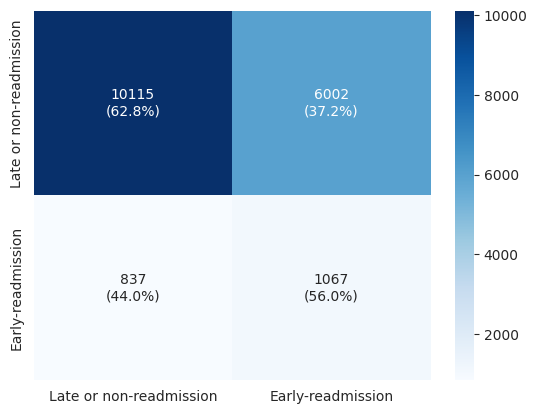

In [40]:
# Visualize confusion matrix with both absolute and percentage values
cm_rus = confusion_matrix(y_test, y_test_pred_rus)
cm_rus_norm = confusion_matrix(y_test, y_test_pred_rus, normalize='true')

annotations_rus = np.array([
    [f"{val}\n({perc:.1%})" for val, perc in zip(row, norm_row)]
    for row, norm_row in zip(cm_rus, cm_rus_norm)
])

sns.heatmap(
    cm_rus,
    annot=annotations_rus,
    cmap='Blues',
    fmt='',
    xticklabels=['Late or non-readmission', 'Early-readmission'],
    yticklabels=['Late or non-readmission', 'Early-readmission']
)

## **4. Optuna Hyper-parameter Tuning | SMOTE**
Hyper-parameter tuning of the model using Optuna, and oversampling with SMOTE.

### 4.1 Objective & study setup
Preparing the objective function with all hyper-parameters, and creating/loading the Optuna study.

In [41]:
def objective(trial: optuna.Trial) -> float:
    # Hyperparameter search space
    params = {
        "n_estimators": 100,
        "max_depth": trial.suggest_int("max_depth", 14, 40, step=2),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 16, 100, step=2)
    }
    
    # Build pipeline
    pipeline = make_pipeline(
        SMOTE(random_state=RANDOM_STATE),
        RandomForestClassifier(**params, random_state=RANDOM_STATE)
    )
    
    # Define validation folds
    kf = StratifiedKFold(n_splits=5, shuffle=False)
    
    # Cross validation
    f1_score = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring=SCORING)

    print("Cross validation F1-scores: {}".format(f1_score))
    print("Average F1-score: {}".format(f1_score.mean()))

    return f1_score.mean()

In [42]:
# Set up study with name and storage
storage = JournalStorage(JournalFileBackend(STUDY_PATH_SMOTE))

study = optuna.create_study(
    direction="maximize",
    study_name=STUDY_NAME,
    storage=storage,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(constant_liar=True, seed=RANDOM_STATE),
    pruner=optuna.pruners.SuccessiveHalvingPruner()
)

optuna.logging.set_verbosity(optuna.logging.INFO)

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/optuna/_experimental.py:31: ExperimentalWarning:

Argument ``constant_liar`` is an experimental feature. The interface can change in the future.

[I 2024-12-29 18:16:29,728] A new study created in Journal with name: Diabetes_130-US


### 4.2 Hyper-parameter tuning
**(CAUTION)** <u>Do not run</u>, unless you already need to find the best parameters. If you already have bound the best model configuration, <u>run the section above</u> _(Objective & study setup)_.

In [43]:
study.optimize(
    objective,
    n_trials=N_TRIALS,
    n_jobs=-1 # Use all available cores
)

[I 2024-12-29 18:16:54,431] Trial 7 finished with value: 0.539804361220507 and parameters: {'max_depth': 36, 'min_samples_leaf': 98}. Best is trial 7 with value: 0.539804361220507.


Cross validation F1-scores: [0.53244611 0.5364641  0.54398025 0.5367451  0.54938624]
Average F1-score: 0.539804361220507


[I 2024-12-29 18:16:54,860] Trial 9 finished with value: 0.5390607161605893 and parameters: {'max_depth': 38, 'min_samples_leaf': 84}. Best is trial 7 with value: 0.539804361220507.


Cross validation F1-scores: [0.53271957 0.53632121 0.54480907 0.53463901 0.54681472]
Average F1-score: 0.5390607161605893


[I 2024-12-29 18:16:55,487] Trial 10 finished with value: 0.5378220918653698 and parameters: {'max_depth': 38, 'min_samples_leaf': 74}. Best is trial 7 with value: 0.539804361220507.
[I 2024-12-29 18:16:55,524] Trial 5 finished with value: 0.5378220918653698 and parameters: {'max_depth': 40, 'min_samples_leaf': 74}. Best is trial 7 with value: 0.539804361220507.


Cross validation F1-scores: [0.53163905 0.53316953 0.54447051 0.53278374 0.54704763]
Average F1-score: 0.5378220918653698
Cross validation F1-scores: [0.53163905 0.53316953 0.54447051 0.53278374 0.54704763]
Average F1-score: 0.5378220918653698


[I 2024-12-29 18:16:55,905] Trial 0 finished with value: 0.5394218510876956 and parameters: {'max_depth': 38, 'min_samples_leaf': 60}. Best is trial 7 with value: 0.539804361220507.


Cross validation F1-scores: [0.53362113 0.53565698 0.54434388 0.53835662 0.54513064]
Average F1-score: 0.5394218510876956


[I 2024-12-29 18:16:56,324] Trial 4 finished with value: 0.5373472820484441 and parameters: {'max_depth': 36, 'min_samples_leaf': 54}. Best is trial 7 with value: 0.539804361220507.
[I 2024-12-29 18:16:56,406] Trial 8 finished with value: 0.5361806252814145 and parameters: {'max_depth': 36, 'min_samples_leaf': 56}. Best is trial 7 with value: 0.539804361220507.


Cross validation F1-scores: [0.53125903 0.5347292  0.54260219 0.53652299 0.54162301]
Average F1-score: 0.5373472820484441
Cross validation F1-scores: [0.52995752 0.52860096 0.54329765 0.53337629 0.54567069]
Average F1-score: 0.5361806252814145


[I 2024-12-29 18:16:56,895] Trial 2 finished with value: 0.5367728924184628 and parameters: {'max_depth': 20, 'min_samples_leaf': 42}. Best is trial 7 with value: 0.539804361220507.


Cross validation F1-scores: [0.52929717 0.53087103 0.54122534 0.53665161 0.54581931]
Average F1-score: 0.5367728924184628


[I 2024-12-29 18:16:58,012] Trial 11 finished with value: 0.5365209232345409 and parameters: {'max_depth': 26, 'min_samples_leaf': 32}. Best is trial 7 with value: 0.539804361220507.
[I 2024-12-29 18:16:58,016] Trial 3 finished with value: 0.5349646146584763 and parameters: {'max_depth': 34, 'min_samples_leaf': 30}. Best is trial 7 with value: 0.539804361220507.


Cross validation F1-scores: [0.53244935 0.52860897 0.5436245  0.53982382 0.53809797]
Average F1-score: 0.5365209232345409
Cross validation F1-scores: [0.52762026 0.52468426 0.54655173 0.53755453 0.53841229]
Average F1-score: 0.5349646146584763


[I 2024-12-29 18:16:58,897] Trial 6 finished with value: 0.527847605478178 and parameters: {'max_depth': 28, 'min_samples_leaf': 20}. Best is trial 7 with value: 0.539804361220507.


Cross validation F1-scores: [0.52093108 0.52164398 0.53707297 0.52924591 0.53034409]
Average F1-score: 0.527847605478178


[I 2024-12-29 18:16:59,107] Trial 1 finished with value: 0.5283421403926802 and parameters: {'max_depth': 30, 'min_samples_leaf': 20}. Best is trial 7 with value: 0.539804361220507.


Cross validation F1-scores: [0.52144515 0.52139813 0.53922186 0.52799028 0.53165529]
Average F1-score: 0.5283421403926802


[I 2024-12-29 18:17:20,835] Trial 16 finished with value: 0.5350163056147814 and parameters: {'max_depth': 14, 'min_samples_leaf': 70}. Best is trial 7 with value: 0.539804361220507.


Cross validation F1-scores: [0.53076684 0.52717655 0.53857726 0.53503356 0.54352732]
Average F1-score: 0.5350163056147814


[I 2024-12-29 18:17:21,197] Trial 15 finished with value: 0.540084031150277 and parameters: {'max_depth': 18, 'min_samples_leaf': 90}. Best is trial 15 with value: 0.540084031150277.


Cross validation F1-scores: [0.5353268  0.53267133 0.54470851 0.53612335 0.55159016]
Average F1-score: 0.540084031150277


[I 2024-12-29 18:17:21,740] Trial 19 finished with value: 0.5389809336329459 and parameters: {'max_depth': 36, 'min_samples_leaf': 100}. Best is trial 15 with value: 0.540084031150277.


Cross validation F1-scores: [0.53285964 0.53287706 0.54514553 0.53597377 0.54804866]
Average F1-score: 0.5389809336329459


[I 2024-12-29 18:17:22,603] Trial 12 finished with value: 0.535497981282356 and parameters: {'max_depth': 22, 'min_samples_leaf': 36}. Best is trial 15 with value: 0.540084031150277.


Cross validation F1-scores: [0.52691125 0.52970687 0.54250844 0.53692652 0.54143682]
Average F1-score: 0.535497981282356


[I 2024-12-29 18:17:23,111] Trial 18 finished with value: 0.5349913294868408 and parameters: {'max_depth': 14, 'min_samples_leaf': 18}. Best is trial 15 with value: 0.540084031150277.


Cross validation F1-scores: [0.53348607 0.52834352 0.53981334 0.53550317 0.53781055]
Average F1-score: 0.5349913294868408


[I 2024-12-29 18:17:23,509] Trial 17 finished with value: 0.5358290279891471 and parameters: {'max_depth': 16, 'min_samples_leaf': 36}. Best is trial 15 with value: 0.540084031150277.
[I 2024-12-29 18:17:23,664] Trial 13 finished with value: 0.5353622353128413 and parameters: {'max_depth': 18, 'min_samples_leaf': 20}. Best is trial 15 with value: 0.540084031150277.


Cross validation F1-scores: [0.5282163  0.52729227 0.54515595 0.53627154 0.54220907]
Average F1-score: 0.5358290279891471
Cross validation F1-scores: [0.52714417 0.53399899 0.54790691 0.5313957  0.53636541]
Average F1-score: 0.5353622353128413


[I 2024-12-29 18:17:23,756] Trial 20 finished with value: 0.540357387646899 and parameters: {'max_depth': 32, 'min_samples_leaf': 94}. Best is trial 20 with value: 0.540357387646899.


Cross validation F1-scores: [0.53351887 0.53617146 0.5435181  0.53646029 0.55211821]
Average F1-score: 0.540357387646899


[I 2024-12-29 18:17:24,287] Trial 21 finished with value: 0.5398764829490243 and parameters: {'max_depth': 24, 'min_samples_leaf': 82}. Best is trial 20 with value: 0.540357387646899.


Cross validation F1-scores: [0.53369591 0.53385527 0.54584059 0.5379194  0.54807124]
Average F1-score: 0.5398764829490243


[I 2024-12-29 18:17:25,544] Trial 14 finished with value: 0.5253175544213914 and parameters: {'max_depth': 38, 'min_samples_leaf': 18}. Best is trial 20 with value: 0.540357387646899.
[I 2024-12-29 18:17:25,725] Trial 22 finished with value: 0.5374171362106047 and parameters: {'max_depth': 32, 'min_samples_leaf': 62}. Best is trial 20 with value: 0.540357387646899.


Cross validation F1-scores: [0.5169583  0.52127165 0.53490492 0.52738283 0.52607007]
Average F1-score: 0.5253175544213914
Cross validation F1-scores: [0.52831002 0.53117812 0.54312633 0.53820503 0.54626618]
Average F1-score: 0.5374171362106047


[I 2024-12-29 18:17:25,792] Trial 23 finished with value: 0.5374171362106047 and parameters: {'max_depth': 40, 'min_samples_leaf': 62}. Best is trial 20 with value: 0.540357387646899.


Cross validation F1-scores: [0.52831002 0.53117812 0.54312633 0.53820503 0.54626618]
Average F1-score: 0.5374171362106047


[I 2024-12-29 18:17:46,188] Trial 25 finished with value: 0.5390257846340148 and parameters: {'max_depth': 24, 'min_samples_leaf': 90}. Best is trial 20 with value: 0.540357387646899.


Cross validation F1-scores: [0.53466298 0.53467076 0.54319051 0.53782072 0.54478396]
Average F1-score: 0.5390257846340148


[I 2024-12-29 18:17:46,395] Trial 26 finished with value: 0.5405647956078147 and parameters: {'max_depth': 20, 'min_samples_leaf': 100}. Best is trial 26 with value: 0.5405647956078147.


Cross validation F1-scores: [0.53569233 0.53478777 0.5447196  0.54015326 0.54747103]
Average F1-score: 0.5405647956078147


[I 2024-12-29 18:17:47,569] Trial 27 finished with value: 0.5384003672984424 and parameters: {'max_depth': 28, 'min_samples_leaf': 90}. Best is trial 26 with value: 0.5405647956078147.


Cross validation F1-scores: [0.53314685 0.53325672 0.54226362 0.53748969 0.54584496]
Average F1-score: 0.5384003672984424
Cross validation F1-scores: [0.53002057 0.52899879 0.54471099 0.5351469  0.54067571]
Average F1-score: 0.5359105905202458


[I 2024-12-29 18:17:47,773] Trial 24 finished with value: 0.5359105905202458 and parameters: {'max_depth': 32, 'min_samples_leaf': 48}. Best is trial 26 with value: 0.5405647956078147.
[I 2024-12-29 18:17:48,479] Trial 28 finished with value: 0.5385012717867889 and parameters: {'max_depth': 18, 'min_samples_leaf': 82}. Best is trial 26 with value: 0.5405647956078147.
[I 2024-12-29 18:17:48,540] Trial 30 finished with value: 0.540357387646899 and parameters: {'max_depth': 30, 'min_samples_leaf': 94}. Best is trial 26 with value: 0.5405647956078147.


Cross validation F1-scores: [0.5335674  0.53172223 0.54218169 0.53619259 0.54884245]
Average F1-score: 0.5385012717867889
Cross validation F1-scores: [0.53351887 0.53617146 0.5435181  0.53646029 0.55211821]
Average F1-score: 0.540357387646899


[I 2024-12-29 18:17:49,190] Trial 31 finished with value: 0.5388481164850353 and parameters: {'max_depth': 30, 'min_samples_leaf': 86}. Best is trial 26 with value: 0.5405647956078147.
[I 2024-12-29 18:17:49,231] Trial 29 finished with value: 0.5380106678237777 and parameters: {'max_depth': 26, 'min_samples_leaf': 68}. Best is trial 26 with value: 0.5405647956078147.


Cross validation F1-scores: [0.53099191 0.53871233 0.54268839 0.53743394 0.54441402]
Average F1-score: 0.5388481164850353
Cross validation F1-scores: [0.53228754 0.53431858 0.54412585 0.53722937 0.54209199]
Average F1-score: 0.5380106678237777


[I 2024-12-29 18:17:49,926] Trial 32 finished with value: 0.5385187313263546 and parameters: {'max_depth': 24, 'min_samples_leaf': 78}. Best is trial 26 with value: 0.5405647956078147.


Cross validation F1-scores: [0.53067351 0.53733241 0.54265879 0.53740221 0.54452673]
Average F1-score: 0.5385187313263546


[I 2024-12-29 18:17:50,721] Trial 33 finished with value: 0.5406376238454745 and parameters: {'max_depth': 22, 'min_samples_leaf': 92}. Best is trial 33 with value: 0.5406376238454745.


Cross validation F1-scores: [0.53508165 0.53491638 0.54519194 0.53937874 0.5486194 ]
Average F1-score: 0.5406376238454745


[I 2024-12-29 18:17:51,203] Trial 35 finished with value: 0.5387477561868372 and parameters: {'max_depth': 24, 'min_samples_leaf': 86}. Best is trial 33 with value: 0.5406376238454745.
[I 2024-12-29 18:17:51,337] Trial 34 finished with value: 0.5397363502871763 and parameters: {'max_depth': 20, 'min_samples_leaf': 80}. Best is trial 33 with value: 0.5406376238454745.


Cross validation F1-scores: [0.52987678 0.53757972 0.54336495 0.53655182 0.54636552]
Average F1-score: 0.5387477561868372
Cross validation F1-scores: [0.53047563 0.53452627 0.54726135 0.53718555 0.54923296]
Average F1-score: 0.5397363502871763


[I 2024-12-29 18:18:10,833] Trial 36 finished with value: 0.5359505593258846 and parameters: {'max_depth': 16, 'min_samples_leaf': 96}. Best is trial 33 with value: 0.5406376238454745.


Cross validation F1-scores: [0.53291929 0.52855474 0.5372544  0.53817811 0.54284626]
Average F1-score: 0.5359505593258846


[I 2024-12-29 18:18:11,249] Trial 37 finished with value: 0.5405647956078147 and parameters: {'max_depth': 20, 'min_samples_leaf': 100}. Best is trial 33 with value: 0.5406376238454745.


Cross validation F1-scores: [0.53569233 0.53478777 0.5447196  0.54015326 0.54747103]
Average F1-score: 0.5405647956078147


[I 2024-12-29 18:18:12,757] Trial 38 finished with value: 0.5368930775662966 and parameters: {'max_depth': 16, 'min_samples_leaf': 88}. Best is trial 33 with value: 0.5406376238454745.


Cross validation F1-scores: [0.53668585 0.52757436 0.54203234 0.53328396 0.54488888]
Average F1-score: 0.5368930775662966


[I 2024-12-29 18:18:13,318] Trial 40 finished with value: 0.536471412298676 and parameters: {'max_depth': 18, 'min_samples_leaf': 96}. Best is trial 33 with value: 0.5406376238454745.


Cross validation F1-scores: [0.53348076 0.52820681 0.54014934 0.53452379 0.54599636]
Average F1-score: 0.536471412298676


[I 2024-12-29 18:18:13,992] Trial 39 finished with value: 0.5378220918653698 and parameters: {'max_depth': 32, 'min_samples_leaf': 74}. Best is trial 33 with value: 0.5406376238454745.


Cross validation F1-scores: [0.53163905 0.53316953 0.54447051 0.53278374 0.54704763]
Average F1-score: 0.5378220918653698


[I 2024-12-29 18:18:14,876] Trial 43 finished with value: 0.540357387646899 and parameters: {'max_depth': 30, 'min_samples_leaf': 94}. Best is trial 33 with value: 0.5406376238454745.
[I 2024-12-29 18:18:14,883] Trial 44 finished with value: 0.5389809336329459 and parameters: {'max_depth': 34, 'min_samples_leaf': 100}. Best is trial 33 with value: 0.5406376238454745.
[I 2024-12-29 18:18:14,955] Trial 42 finished with value: 0.540357387646899 and parameters: {'max_depth': 34, 'min_samples_leaf': 94}. Best is trial 33 with value: 0.5406376238454745.


Cross validation F1-scores: [0.53351887 0.53617146 0.5435181  0.53646029 0.55211821]
Average F1-score: 0.540357387646899
Cross validation F1-scores: [0.53285964 0.53287706 0.54514553 0.53597377 0.54804866]
Average F1-score: 0.5389809336329459
Cross validation F1-scores: [0.53351887 0.53617146 0.5435181  0.53646029 0.55211821]
Average F1-score: 0.540357387646899


[I 2024-12-29 18:18:15,866] Trial 41 finished with value: 0.5371697221793561 and parameters: {'max_depth': 30, 'min_samples_leaf': 50}. Best is trial 33 with value: 0.5406376238454745.


Cross validation F1-scores: [0.52576499 0.5357625  0.54406392 0.53677412 0.54348309]
Average F1-score: 0.5371697221793561


[I 2024-12-29 18:18:16,442] Trial 45 finished with value: 0.5406376238454745 and parameters: {'max_depth': 22, 'min_samples_leaf': 92}. Best is trial 33 with value: 0.5406376238454745.


Cross validation F1-scores: [0.53508165 0.53491638 0.54519194 0.53937874 0.5486194 ]
Average F1-score: 0.5406376238454745


[I 2024-12-29 18:18:17,536] Trial 46 finished with value: 0.5383594110978163 and parameters: {'max_depth': 28, 'min_samples_leaf': 76}. Best is trial 33 with value: 0.5406376238454745.


Cross validation F1-scores: [0.53281226 0.532934   0.54336598 0.53877737 0.54390744]
Average F1-score: 0.5383594110978163


[I 2024-12-29 18:18:17,848] Trial 47 finished with value: 0.5390552734980393 and parameters: {'max_depth': 22, 'min_samples_leaf': 68}. Best is trial 33 with value: 0.5406376238454745.


Cross validation F1-scores: [0.53340477 0.53198797 0.54583506 0.53796206 0.54608651]
Average F1-score: 0.5390552734980393


[I 2024-12-29 18:18:35,555] Trial 48 finished with value: 0.5380850603570118 and parameters: {'max_depth': 26, 'min_samples_leaf': 96}. Best is trial 33 with value: 0.5406376238454745.


Cross validation F1-scores: [0.53389298 0.53323796 0.53815824 0.54013564 0.54500047]
Average F1-score: 0.5380850603570118


[I 2024-12-29 18:18:35,992] Trial 49 finished with value: 0.5391184781529011 and parameters: {'max_depth': 22, 'min_samples_leaf': 100}. Best is trial 33 with value: 0.5406376238454745.


Cross validation F1-scores: [0.53431114 0.53452044 0.54373569 0.5377787  0.54524643]
Average F1-score: 0.5391184781529011


[I 2024-12-29 18:18:38,029] Trial 51 finished with value: 0.5383256073829668 and parameters: {'max_depth': 20, 'min_samples_leaf': 86}. Best is trial 33 with value: 0.5406376238454745.


Cross validation F1-scores: [0.53293637 0.53470606 0.53985117 0.53540499 0.54872944]
Average F1-score: 0.5383256073829668


[I 2024-12-29 18:18:38,817] Trial 52 finished with value: 0.5409131910830262 and parameters: {'max_depth': 20, 'min_samples_leaf': 92}. Best is trial 52 with value: 0.5409131910830262.


Cross validation F1-scores: [0.5347649  0.53449707 0.54789519 0.53644057 0.55096822]
Average F1-score: 0.5409131910830262


[I 2024-12-29 18:18:39,375] Trial 53 finished with value: 0.5382861338715282 and parameters: {'max_depth': 28, 'min_samples_leaf': 96}. Best is trial 52 with value: 0.5409131910830262.
[I 2024-12-29 18:18:39,460] Trial 54 finished with value: 0.5389468381135298 and parameters: {'max_depth': 26, 'min_samples_leaf': 100}. Best is trial 52 with value: 0.5409131910830262.


Cross validation F1-scores: [0.53364289 0.53350062 0.5384768  0.54072399 0.54508637]
Average F1-score: 0.5382861338715282
Cross validation F1-scores: [0.53285964 0.53287706 0.54497506 0.53597377 0.54804866]
Average F1-score: 0.5389468381135298


[I 2024-12-29 18:18:40,026] Trial 55 finished with value: 0.5413564933824566 and parameters: {'max_depth': 34, 'min_samples_leaf': 92}. Best is trial 55 with value: 0.5413564933824566.


Cross validation F1-scores: [0.53500965 0.53442583 0.54780584 0.54127186 0.54826929]
Average F1-score: 0.5413564933824566


[I 2024-12-29 18:18:40,562] Trial 50 finished with value: 0.5345516449448907 and parameters: {'max_depth': 20, 'min_samples_leaf': 24}. Best is trial 55 with value: 0.5413564933824566.


Cross validation F1-scores: [0.52227972 0.53088843 0.54647174 0.53218913 0.5409292 ]
Average F1-score: 0.5345516449448907


[I 2024-12-29 18:18:40,806] Trial 56 finished with value: 0.5390607161605893 and parameters: {'max_depth': 32, 'min_samples_leaf': 84}. Best is trial 55 with value: 0.5413564933824566.


Cross validation F1-scores: [0.53271957 0.53632121 0.54480907 0.53463901 0.54681472]
Average F1-score: 0.5390607161605893


[I 2024-12-29 18:18:41,302] Trial 57 finished with value: 0.5386038464430045 and parameters: {'max_depth': 22, 'min_samples_leaf': 90}. Best is trial 55 with value: 0.5413564933824566.


Cross validation F1-scores: [0.53376815 0.53317556 0.54209238 0.53902033 0.54496281]
Average F1-score: 0.5386038464430045


[I 2024-12-29 18:18:42,086] Trial 58 finished with value: 0.5392078088784366 and parameters: {'max_depth': 22, 'min_samples_leaf': 98}. Best is trial 55 with value: 0.5413564933824566.


Cross validation F1-scores: [0.53421471 0.5336232  0.54179491 0.53745968 0.54894654]
Average F1-score: 0.5392078088784366


[I 2024-12-29 18:18:43,051] Trial 59 finished with value: 0.5380018862543468 and parameters: {'max_depth': 18, 'min_samples_leaf': 80}. Best is trial 55 with value: 0.5413564933824566.


Cross validation F1-scores: [0.5321279  0.53137577 0.54357595 0.53828528 0.54464453]
Average F1-score: 0.5380018862543468


[I 2024-12-29 18:19:00,350] Trial 60 finished with value: 0.5401707641050487 and parameters: {'max_depth': 24, 'min_samples_leaf': 88}. Best is trial 55 with value: 0.5413564933824566.


Cross validation F1-scores: [0.53480152 0.53314009 0.54656634 0.53796008 0.5483858 ]
Average F1-score: 0.5401707641050487


[I 2024-12-29 18:19:00,757] Trial 61 finished with value: 0.5409131910830262 and parameters: {'max_depth': 20, 'min_samples_leaf': 92}. Best is trial 55 with value: 0.5413564933824566.


Cross validation F1-scores: [0.5347649  0.53449707 0.54789519 0.53644057 0.55096822]
Average F1-score: 0.5409131910830262


[I 2024-12-29 18:19:02,599] Trial 62 finished with value: 0.540357387646899 and parameters: {'max_depth': 30, 'min_samples_leaf': 94}. Best is trial 55 with value: 0.5413564933824566.


Cross validation F1-scores: [0.53351887 0.53617146 0.5435181  0.53646029 0.55211821]
Average F1-score: 0.540357387646899


[I 2024-12-29 18:19:03,158] Trial 63 finished with value: 0.5382907399842488 and parameters: {'max_depth': 20, 'min_samples_leaf': 98}. Best is trial 55 with value: 0.5413564933824566.


Cross validation F1-scores: [0.53374624 0.53236769 0.54218172 0.53533969 0.54781836]
Average F1-score: 0.5382907399842488


[I 2024-12-29 18:19:03,687] Trial 64 finished with value: 0.5379072078776932 and parameters: {'max_depth': 16, 'min_samples_leaf': 92}. Best is trial 55 with value: 0.5413564933824566.


Cross validation F1-scores: [0.5370863  0.52743581 0.54094839 0.53468239 0.54938316]
Average F1-score: 0.5379072078776932


[I 2024-12-29 18:19:04,457] Trial 65 finished with value: 0.5384038422416736 and parameters: {'max_depth': 18, 'min_samples_leaf': 84}. Best is trial 55 with value: 0.5413564933824566.
[I 2024-12-29 18:19:04,562] Trial 69 finished with value: 0.5336960670777859 and parameters: {'max_depth': 14, 'min_samples_leaf': 98}. Best is trial 55 with value: 0.5413564933824566.


Cross validation F1-scores: [0.5355904  0.53185644 0.54238371 0.53637775 0.54581091]
Average F1-score: 0.5384038422416736
Cross validation F1-scores: [0.53244933 0.5234368  0.5389792  0.52952837 0.54408663]
Average F1-score: 0.5336960670777859


[I 2024-12-29 18:19:04,800] Trial 66 finished with value: 0.5395395609425453 and parameters: {'max_depth': 22, 'min_samples_leaf': 88}. Best is trial 55 with value: 0.5413564933824566.


Cross validation F1-scores: [0.53539793 0.53443003 0.54677657 0.53410465 0.54698862]
Average F1-score: 0.5395395609425453


[I 2024-12-29 18:19:05,588] Trial 68 finished with value: 0.5410863965184526 and parameters: {'max_depth': 24, 'min_samples_leaf': 92}. Best is trial 55 with value: 0.5413564933824566.


Cross validation F1-scores: [0.53590949 0.53434425 0.54747444 0.54004563 0.54765817]
Average F1-score: 0.5410863965184526


[I 2024-12-29 18:19:07,037] Trial 70 finished with value: 0.5396990310288932 and parameters: {'max_depth': 40, 'min_samples_leaf': 82}. Best is trial 55 with value: 0.5413564933824566.


Cross validation F1-scores: [0.53498822 0.53548938 0.54472614 0.53755283 0.54573859]
Average F1-score: 0.5396990310288932


[I 2024-12-29 18:19:07,416] Trial 67 finished with value: 0.5367728924184628 and parameters: {'max_depth': 20, 'min_samples_leaf': 42}. Best is trial 55 with value: 0.5413564933824566.


Cross validation F1-scores: [0.52929717 0.53087103 0.54122534 0.53665161 0.54581931]
Average F1-score: 0.5367728924184628


[I 2024-12-29 18:19:08,153] Trial 71 finished with value: 0.5386038464430045 and parameters: {'max_depth': 22, 'min_samples_leaf': 90}. Best is trial 55 with value: 0.5413564933824566.


Cross validation F1-scores: [0.53376815 0.53317556 0.54209238 0.53902033 0.54496281]
Average F1-score: 0.5386038464430045


[I 2024-12-29 18:19:25,248] Trial 72 finished with value: 0.5413564933824566 and parameters: {'max_depth': 36, 'min_samples_leaf': 92}. Best is trial 55 with value: 0.5413564933824566.


Cross validation F1-scores: [0.53500965 0.53442583 0.54780584 0.54127186 0.54826929]
Average F1-score: 0.5413564933824566


[I 2024-12-29 18:19:25,579] Trial 73 finished with value: 0.5409131910830262 and parameters: {'max_depth': 20, 'min_samples_leaf': 92}. Best is trial 55 with value: 0.5413564933824566.


Cross validation F1-scores: [0.5347649  0.53449707 0.54789519 0.53644057 0.55096822]
Average F1-score: 0.5409131910830262


[I 2024-12-29 18:19:27,274] Trial 74 finished with value: 0.5382907399842488 and parameters: {'max_depth': 20, 'min_samples_leaf': 98}. Best is trial 55 with value: 0.5413564933824566.


Cross validation F1-scores: [0.53374624 0.53236769 0.54218172 0.53533969 0.54781836]
Average F1-score: 0.5382907399842488


[I 2024-12-29 18:19:28,138] Trial 75 finished with value: 0.5386717729785783 and parameters: {'max_depth': 18, 'min_samples_leaf': 86}. Best is trial 55 with value: 0.5413564933824566.
[I 2024-12-29 18:19:28,140] Trial 76 finished with value: 0.5391184781529011 and parameters: {'max_depth': 22, 'min_samples_leaf': 100}. Best is trial 55 with value: 0.5413564933824566.


Cross validation F1-scores: [0.53124225 0.53287073 0.54247245 0.53704768 0.54972575]
Average F1-score: 0.5386717729785783
Cross validation F1-scores: [0.53431114 0.53452044 0.54373569 0.5377787  0.54524643]
Average F1-score: 0.5391184781529011


[I 2024-12-29 18:19:28,797] Trial 78 finished with value: 0.5368930775662966 and parameters: {'max_depth': 16, 'min_samples_leaf': 88}. Best is trial 55 with value: 0.5413564933824566.


Cross validation F1-scores: [0.53668585 0.52757436 0.54203234 0.53328396 0.54488888]
Average F1-score: 0.5368930775662966


[I 2024-12-29 18:19:29,337] Trial 79 finished with value: 0.5368858377190913 and parameters: {'max_depth': 20, 'min_samples_leaf': 96}. Best is trial 55 with value: 0.5413564933824566.


Cross validation F1-scores: [0.53179249 0.53259582 0.54060143 0.53654287 0.54289659]
Average F1-score: 0.5368858377190913


[I 2024-12-29 18:19:29,994] Trial 77 finished with value: 0.5379543487125884 and parameters: {'max_depth': 18, 'min_samples_leaf': 70}. Best is trial 55 with value: 0.5413564933824566.


Cross validation F1-scores: [0.53191207 0.53095871 0.54369527 0.5363613  0.5468444 ]
Average F1-score: 0.5379543487125884


[I 2024-12-29 18:19:30,711] Trial 80 finished with value: 0.5385187313263546 and parameters: {'max_depth': 24, 'min_samples_leaf': 78}. Best is trial 55 with value: 0.5413564933824566.


Cross validation F1-scores: [0.53067351 0.53733241 0.54265879 0.53740221 0.54452673]
Average F1-score: 0.5385187313263546


[I 2024-12-29 18:19:31,915] Trial 81 finished with value: 0.5410863965184526 and parameters: {'max_depth': 24, 'min_samples_leaf': 92}. Best is trial 55 with value: 0.5413564933824566.


Cross validation F1-scores: [0.53590949 0.53434425 0.54747444 0.54004563 0.54765817]
Average F1-score: 0.5410863965184526


[I 2024-12-29 18:19:32,163] Trial 82 finished with value: 0.5406376238454745 and parameters: {'max_depth': 22, 'min_samples_leaf': 92}. Best is trial 55 with value: 0.5413564933824566.


Cross validation F1-scores: [0.53508165 0.53491638 0.54519194 0.53937874 0.5486194 ]
Average F1-score: 0.5406376238454745


[I 2024-12-29 18:19:32,746] Trial 83 finished with value: 0.5393990048713629 and parameters: {'max_depth': 20, 'min_samples_leaf': 94}. Best is trial 55 with value: 0.5413564933824566.


Cross validation F1-scores: [0.531      0.53617146 0.54375695 0.53759975 0.54846687]
Average F1-score: 0.5393990048713629


[I 2024-12-29 18:19:50,139] Trial 84 finished with value: 0.5384003672984424 and parameters: {'max_depth': 38, 'min_samples_leaf': 90}. Best is trial 55 with value: 0.5413564933824566.


Cross validation F1-scores: [0.53314685 0.53325672 0.54226362 0.53748969 0.54584496]
Average F1-score: 0.5384003672984424


[I 2024-12-29 18:19:50,461] Trial 85 finished with value: 0.5390607161605893 and parameters: {'max_depth': 36, 'min_samples_leaf': 84}. Best is trial 55 with value: 0.5413564933824566.


Cross validation F1-scores: [0.53271957 0.53632121 0.54480907 0.53463901 0.54681472]
Average F1-score: 0.5390607161605893


[I 2024-12-29 18:19:52,245] Trial 86 finished with value: 0.5413564933824566 and parameters: {'max_depth': 36, 'min_samples_leaf': 92}. Best is trial 55 with value: 0.5413564933824566.


Cross validation F1-scores: [0.53500965 0.53442583 0.54780584 0.54127186 0.54826929]
Average F1-score: 0.5413564933824566


[I 2024-12-29 18:19:52,848] Trial 88 finished with value: 0.5413564933824566 and parameters: {'max_depth': 38, 'min_samples_leaf': 92}. Best is trial 55 with value: 0.5413564933824566.


Cross validation F1-scores: [0.53500965 0.53442583 0.54780584 0.54127186 0.54826929]
Average F1-score: 0.5413564933824566


[I 2024-12-29 18:19:53,502] Trial 87 finished with value: 0.5396990310288932 and parameters: {'max_depth': 34, 'min_samples_leaf': 82}. Best is trial 55 with value: 0.5413564933824566.


Cross validation F1-scores: [0.53498822 0.53548938 0.54472614 0.53755283 0.54573859]
Average F1-score: 0.5396990310288932


[I 2024-12-29 18:19:54,009] Trial 90 finished with value: 0.5397461015256212 and parameters: {'max_depth': 26, 'min_samples_leaf': 88}. Best is trial 55 with value: 0.5413564933824566.


Cross validation F1-scores: [0.53505924 0.53452145 0.54600559 0.53621277 0.54693146]
Average F1-score: 0.5397461015256212


[I 2024-12-29 18:19:54,598] Trial 89 finished with value: 0.5380155017495084 and parameters: {'max_depth': 24, 'min_samples_leaf': 58}. Best is trial 55 with value: 0.5413564933824566.


Cross validation F1-scores: [0.53082696 0.53319128 0.5460888  0.5401787  0.53979178]
Average F1-score: 0.5380155017495084


[I 2024-12-29 18:19:54,986] Trial 91 finished with value: 0.5383879698760295 and parameters: {'max_depth': 22, 'min_samples_leaf': 86}. Best is trial 55 with value: 0.5413564933824566.
[I 2024-12-29 18:19:55,167] Trial 92 finished with value: 0.5368858377190913 and parameters: {'max_depth': 20, 'min_samples_leaf': 96}. Best is trial 55 with value: 0.5413564933824566.


Cross validation F1-scores: [0.53252746 0.53496456 0.54234971 0.53773885 0.54435928]
Average F1-score: 0.5383879698760295
Cross validation F1-scores: [0.53179249 0.53259582 0.54060143 0.53654287 0.54289659]
Average F1-score: 0.5368858377190913


[I 2024-12-29 18:19:56,126] Trial 93 finished with value: 0.5410863965184526 and parameters: {'max_depth': 24, 'min_samples_leaf': 92}. Best is trial 55 with value: 0.5413564933824566.
[I 2024-12-29 18:19:56,187] Trial 94 finished with value: 0.5390257846340148 and parameters: {'max_depth': 24, 'min_samples_leaf': 90}. Best is trial 55 with value: 0.5413564933824566.


Cross validation F1-scores: [0.53590949 0.53434425 0.54747444 0.54004563 0.54765817]
Average F1-score: 0.5410863965184526
Cross validation F1-scores: [0.53466298 0.53467076 0.54319051 0.53782072 0.54478396]
Average F1-score: 0.5390257846340148


[I 2024-12-29 18:19:56,603] Trial 95 finished with value: 0.5410863965184526 and parameters: {'max_depth': 24, 'min_samples_leaf': 92}. Best is trial 55 with value: 0.5413564933824566.


Cross validation F1-scores: [0.53590949 0.53434425 0.54747444 0.54004563 0.54765817]
Average F1-score: 0.5410863965184526


[I 2024-12-29 18:20:07,424] Trial 97 finished with value: 0.540357387646899 and parameters: {'max_depth': 28, 'min_samples_leaf': 94}. Best is trial 55 with value: 0.5413564933824566.


Cross validation F1-scores: [0.53351887 0.53617146 0.5435181  0.53646029 0.55211821]
Average F1-score: 0.540357387646899


[I 2024-12-29 18:20:07,678] Trial 96 finished with value: 0.5381252950581846 and parameters: {'max_depth': 26, 'min_samples_leaf': 80}. Best is trial 55 with value: 0.5413564933824566.


Cross validation F1-scores: [0.53243182 0.53570666 0.543788   0.53262727 0.54607272]
Average F1-score: 0.5381252950581846


[I 2024-12-29 18:20:09,021] Trial 98 finished with value: 0.5388481164850353 and parameters: {'max_depth': 36, 'min_samples_leaf': 86}. Best is trial 55 with value: 0.5413564933824566.


Cross validation F1-scores: [0.53099191 0.53871233 0.54268839 0.53743394 0.54441402]
Average F1-score: 0.5388481164850353


[I 2024-12-29 18:20:09,244] Trial 99 finished with value: 0.5384003672984424 and parameters: {'max_depth': 38, 'min_samples_leaf': 90}. Best is trial 55 with value: 0.5413564933824566.


Cross validation F1-scores: [0.53314685 0.53325672 0.54226362 0.53748969 0.54584496]
Average F1-score: 0.5384003672984424


In [44]:
print('Best Trial: {}'.format(study.best_trial.number))
print('Best Parameters: {}'.format(study.best_params))
print('Best Value: {}'.format(study.best_value))

Best Trial: 55
Best Parameters: {'max_depth': 34, 'min_samples_leaf': 92}
Best Value: 0.5413564933824566


### 4.3 Optuna Visualizations
Visualizing hyper-parameter tuning results obtained by running Optuna.

In [45]:
optuna.visualization.plot_optimization_history(study)

In [46]:
optuna.visualization.plot_slice(study)

In [47]:
optuna.visualization.plot_param_importances(study)

In [48]:
optuna.visualization.plot_parallel_coordinate(study)

In [49]:
optuna.visualization.plot_contour(study)

In [50]:
optuna.visualization.plot_timeline(study)

### 4.4 Fitting Best Model
Fitting the final model using the best hyper-parameters found by Optuna.

In [51]:
# Fit best model on the training set
best_params = study.best_params

pipeline_smote = make_pipeline(
    SMOTE(random_state=RANDOM_STATE),
    RandomForestClassifier(**best_params, random_state=RANDOM_STATE)
)

pipeline_smote.fit(X_train, y_train)

Pipeline(steps=[('smote', SMOTE(random_state=38)),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=34, min_samples_leaf=92,
                                        random_state=38))])

In [52]:
# Predictions
y_train_pred_smote = pipeline_smote.predict(X_train)
y_test_pred_smote = pipeline_smote.predict(X_test)

In [53]:
ac_train_smote = accuracy_score(y_train, y_train_pred_smote)
ac_test_smote = accuracy_score(y_test, y_test_pred_smote)

print('Train accuracy: ', ac_train_smote)
print('Test accuracy: ', ac_test_smote)

Train accuracy:  0.8051274733637748
Test accuracy:  0.7878586094001443


In [54]:
# Visualize precision, recall, F1-score
print(classification_report(
    y_test, y_test_pred_smote,
    target_names=['Late or non-readmission', 'Early-readmission']
))

                         precision    recall  f1-score   support

Late or non-readmission       0.91      0.85      0.88     16117
      Early-readmission       0.17      0.26      0.21      1904

               accuracy                           0.79     18021
              macro avg       0.54      0.56      0.54     18021
           weighted avg       0.83      0.79      0.81     18021



In [55]:
# Compute precision, recall, F1-score, ROC-AUC-score, and accuracy
recall_smote = recall_score(y_test, y_test_pred_smote, average='macro')
precision_smote = precision_score(y_test, y_test_pred_smote, average='macro')
f1_smote = f1_score(y_test, y_test_pred_smote, average='macro')
roc_auc_smote = roc_auc_score(y_test, y_test_pred_smote, average='macro')
accuracy_smote = accuracy_score(y_test, y_test_pred_smote)

<Axes: >

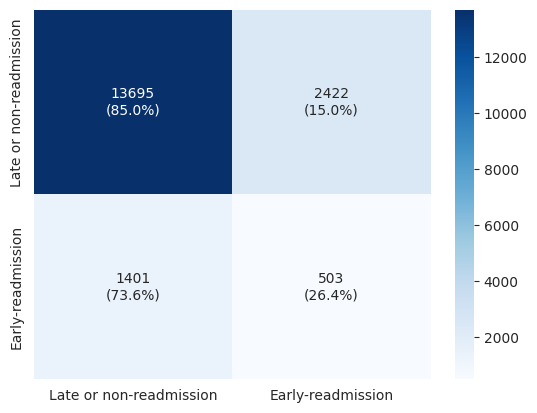

In [56]:
# Visualize confusion matrix with both absolute and percentage values
cm_smote = confusion_matrix(y_test, y_test_pred_smote)
cm_smote_norm = confusion_matrix(y_test, y_test_pred_smote, normalize='true')

annotations_smote = np.array([
    [f"{val}\n({perc:.1%})" for val, perc in zip(row, norm_row)]
    for row, norm_row in zip(cm_smote, cm_smote_norm)
])

sns.heatmap(
    cm_smote,
    annot=annotations_smote,
    cmap='Blues',
    fmt='',
    xticklabels=['Late or non-readmission', 'Early-readmission'],
    yticklabels=['Late or non-readmission', 'Early-readmission']
)

## **5. Optuna Hyper-parameter Tuning | SMOTE + Tomek Links**
Hyper-parameter tuning of the model using Optuna, by oversampling with SMOTE and undersampling with Tomek Links.

### 5.1 Objective & study setup
Preparing the objective function with all hyper-parameters, and creating/loading the Optuna study.

In [57]:
def objective(trial: optuna.Trial) -> float:
    # Hyperparameter search space
    params = {
        "n_estimators": 100,
        "max_depth": trial.suggest_int("max_depth", 14, 40, step=2),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 16, 100, step=2)
    }
    
    # Build pipeline
    pipeline = make_pipeline(
        SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'), random_state=RANDOM_STATE),
        RandomForestClassifier(**params, random_state=RANDOM_STATE)
    )
    
    # Define validation folds
    kf = StratifiedKFold(n_splits=5, shuffle=False)
    
    # Cross validation
    f1_score = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring=SCORING)

    print("Cross validation F1-scores: {}".format(f1_score))
    print("Average F1-score: {}".format(f1_score.mean()))

    return f1_score.mean()

In [58]:
# Set up study with name and storage
storage = JournalStorage(JournalFileBackend(STUDY_PATH_SMOTE_TOMEK))

study = optuna.create_study(
    direction="maximize",
    study_name=STUDY_NAME,
    storage=storage,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(constant_liar=True, seed=RANDOM_STATE),
    pruner=optuna.pruners.SuccessiveHalvingPruner()
)

optuna.logging.set_verbosity(optuna.logging.INFO)

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/optuna/_experimental.py:31: ExperimentalWarning:

Argument ``constant_liar`` is an experimental feature. The interface can change in the future.

[I 2024-12-29 18:20:13,772] A new study created in Journal with name: Diabetes_130-US


### 5.2 Hyper-parameter tuning
**(CAUTION)** <u>Do not run</u>, unless you already need to find the best parameters. If you already have bound the best model configuration, <u>run the section above</u> _(Objective & study setup)_.

In [59]:
study.optimize(
    objective,
    n_trials=N_TRIALS,
    n_jobs=-1 # Use all available cores
)

[I 2024-12-29 18:20:54,586] Trial 8 finished with value: 0.5356828994187735 and parameters: {'max_depth': 22, 'min_samples_leaf': 90}. Best is trial 8 with value: 0.5356828994187735.


Cross validation F1-scores: [0.53090957 0.52616508 0.54119316 0.53422767 0.54591902]
Average F1-score: 0.5356828994187735


[I 2024-12-29 18:20:57,149] Trial 4 finished with value: 0.5361018957096706 and parameters: {'max_depth': 32, 'min_samples_leaf': 34}. Best is trial 4 with value: 0.5361018957096706.
[I 2024-12-29 18:20:57,227] Trial 3 finished with value: 0.5324838050673228 and parameters: {'max_depth': 34, 'min_samples_leaf': 22}. Best is trial 4 with value: 0.5361018957096706.


Cross validation F1-scores: [0.52820166 0.53551539 0.54295802 0.53394126 0.53989315]
Average F1-score: 0.5361018957096706
Cross validation F1-scores: [0.52952906 0.52938278 0.53962652 0.53179724 0.53208343]
Average F1-score: 0.5324838050673228


[I 2024-12-29 18:20:57,464] Trial 5 finished with value: 0.5364679942426053 and parameters: {'max_depth': 24, 'min_samples_leaf': 70}. Best is trial 5 with value: 0.5364679942426053.


Cross validation F1-scores: [0.53166144 0.53380614 0.5377804  0.53403461 0.54505739]
Average F1-score: 0.5364679942426053


[I 2024-12-29 18:20:57,880] Trial 0 finished with value: 0.5359930203544897 and parameters: {'max_depth': 30, 'min_samples_leaf': 38}. Best is trial 5 with value: 0.5364679942426053.
[I 2024-12-29 18:20:57,966] Trial 2 finished with value: 0.5361415763020105 and parameters: {'max_depth': 26, 'min_samples_leaf': 54}. Best is trial 5 with value: 0.5364679942426053.


Cross validation F1-scores: [0.53059473 0.5323143  0.54079434 0.5382268  0.53803494]
Average F1-score: 0.5359930203544897
Cross validation F1-scores: [0.53107814 0.53066445 0.54064333 0.53422073 0.54410123]
Average F1-score: 0.5361415763020105


[I 2024-12-29 18:20:58,379] Trial 9 finished with value: 0.5364008940556777 and parameters: {'max_depth': 20, 'min_samples_leaf': 52}. Best is trial 5 with value: 0.5364679942426053.


Cross validation F1-scores: [0.52876109 0.53216757 0.54242128 0.53636507 0.54228945]
Average F1-score: 0.5364008940556777


[I 2024-12-29 18:20:59,866] Trial 10 finished with value: 0.5353063977998985 and parameters: {'max_depth': 18, 'min_samples_leaf': 40}. Best is trial 5 with value: 0.5364679942426053.


Cross validation F1-scores: [0.53089136 0.52916121 0.53899504 0.53573063 0.54175375]
Average F1-score: 0.5353063977998985


[I 2024-12-29 18:21:00,194] Trial 7 finished with value: 0.533935079037095 and parameters: {'max_depth': 40, 'min_samples_leaf': 36}. Best is trial 5 with value: 0.5364679942426053.


Cross validation F1-scores: [0.5254506  0.53183198 0.54135127 0.53352209 0.53751945]
Average F1-score: 0.533935079037095


[I 2024-12-29 18:21:00,536] Trial 6 finished with value: 0.5346877567335884 and parameters: {'max_depth': 36, 'min_samples_leaf': 46}. Best is trial 5 with value: 0.5364679942426053.


Cross validation F1-scores: [0.52474643 0.53524977 0.54092013 0.53210322 0.54041923]
Average F1-score: 0.5346877567335884


[I 2024-12-29 18:21:00,973] Trial 1 finished with value: 0.5340983227028806 and parameters: {'max_depth': 26, 'min_samples_leaf': 36}. Best is trial 5 with value: 0.5364679942426053.


Cross validation F1-scores: [0.52508036 0.53221289 0.54114441 0.53685129 0.53520266]
Average F1-score: 0.5340983227028806


[I 2024-12-29 18:21:01,995] Trial 11 finished with value: 0.532506100942282 and parameters: {'max_depth': 36, 'min_samples_leaf': 22}. Best is trial 5 with value: 0.5364679942426053.


Cross validation F1-scores: [0.52952906 0.5296115  0.53953003 0.53177649 0.53208343]
Average F1-score: 0.532506100942282


[I 2024-12-29 18:21:37,016] Trial 12 finished with value: 0.5346877567335884 and parameters: {'max_depth': 36, 'min_samples_leaf': 46}. Best is trial 5 with value: 0.5364679942426053.


Cross validation F1-scores: [0.52474643 0.53524977 0.54092013 0.53210322 0.54041923]
Average F1-score: 0.5346877567335884


[I 2024-12-29 18:21:37,526] Trial 17 finished with value: 0.5305566045304653 and parameters: {'max_depth': 14, 'min_samples_leaf': 82}. Best is trial 5 with value: 0.5364679942426053.


Cross validation F1-scores: [0.5266702  0.52449703 0.53021468 0.52976472 0.5416364 ]
Average F1-score: 0.5305566045304653


[I 2024-12-29 18:21:38,922] Trial 14 finished with value: 0.5373942863494069 and parameters: {'max_depth': 26, 'min_samples_leaf': 68}. Best is trial 14 with value: 0.5373942863494069.


Cross validation F1-scores: [0.53059528 0.53209672 0.54128146 0.53379374 0.54920423]
Average F1-score: 0.5373942863494069


[I 2024-12-29 18:21:39,475] Trial 15 finished with value: 0.5332825454712171 and parameters: {'max_depth': 16, 'min_samples_leaf': 54}. Best is trial 14 with value: 0.5373942863494069.


Cross validation F1-scores: [0.53076684 0.52806771 0.53660288 0.52864236 0.54233294]
Average F1-score: 0.5332825454712171


[I 2024-12-29 18:21:39,742] Trial 18 finished with value: 0.5337369280702962 and parameters: {'max_depth': 20, 'min_samples_leaf': 88}. Best is trial 14 with value: 0.5373942863494069.


Cross validation F1-scores: [0.52538558 0.52629693 0.53673262 0.53398373 0.54628578]
Average F1-score: 0.5337369280702962


[I 2024-12-29 18:21:40,939] Trial 19 finished with value: 0.5348451357638659 and parameters: {'max_depth': 26, 'min_samples_leaf': 94}. Best is trial 14 with value: 0.5373942863494069.


Cross validation F1-scores: [0.52680305 0.52853444 0.54208678 0.53123173 0.54556968]
Average F1-score: 0.5348451357638659


[I 2024-12-29 18:21:41,376] Trial 16 finished with value: 0.5354140073475656 and parameters: {'max_depth': 22, 'min_samples_leaf': 48}. Best is trial 14 with value: 0.5373942863494069.


Cross validation F1-scores: [0.52723126 0.53138405 0.54250829 0.53581327 0.54013318]
Average F1-score: 0.5354140073475656


[I 2024-12-29 18:21:41,695] Trial 21 finished with value: 0.5347743125951878 and parameters: {'max_depth': 30, 'min_samples_leaf': 100}. Best is trial 14 with value: 0.5373942863494069.
[I 2024-12-29 18:21:41,809] Trial 13 finished with value: 0.5361940853621917 and parameters: {'max_depth': 40, 'min_samples_leaf': 44}. Best is trial 14 with value: 0.5373942863494069.


Cross validation F1-scores: [0.52968464 0.53032724 0.54001605 0.53147626 0.54236737]
Average F1-score: 0.5347743125951878
Cross validation F1-scores: [0.52974628 0.53254459 0.54195175 0.53648619 0.54024162]
Average F1-score: 0.5361940853621917


[I 2024-12-29 18:21:43,016] Trial 20 finished with value: 0.5356472043444995 and parameters: {'max_depth': 40, 'min_samples_leaf': 70}. Best is trial 14 with value: 0.5373942863494069.


Cross validation F1-scores: [0.53073165 0.53196084 0.53867785 0.53360297 0.54326271]
Average F1-score: 0.5356472043444995


[I 2024-12-29 18:21:43,465] Trial 23 finished with value: 0.5356115144503869 and parameters: {'max_depth': 18, 'min_samples_leaf': 80}. Best is trial 14 with value: 0.5373942863494069.
[I 2024-12-29 18:21:43,656] Trial 22 finished with value: 0.5382732241700582 and parameters: {'max_depth': 22, 'min_samples_leaf': 66}. Best is trial 22 with value: 0.5382732241700582.


Cross validation F1-scores: [0.53147632 0.529567   0.53602347 0.53422735 0.54676343]
Average F1-score: 0.5356115144503869
Cross validation F1-scores: [0.53208057 0.53567225 0.54118675 0.53945436 0.5429722 ]
Average F1-score: 0.5382732241700582


[I 2024-12-29 18:22:16,732] Trial 25 finished with value: 0.5321351797170644 and parameters: {'max_depth': 14, 'min_samples_leaf': 76}. Best is trial 22 with value: 0.5382732241700582.


Cross validation F1-scores: [0.53103531 0.5238874  0.53302611 0.529834   0.54289309]
Average F1-score: 0.5321351797170644


[I 2024-12-29 18:22:17,958] Trial 24 finished with value: 0.535033699925749 and parameters: {'max_depth': 24, 'min_samples_leaf': 62}. Best is trial 22 with value: 0.5382732241700582.


Cross validation F1-scores: [0.52973911 0.53091842 0.53960166 0.53337137 0.54153795]
Average F1-score: 0.535033699925749


[I 2024-12-29 18:22:18,764] Trial 26 finished with value: 0.5367263877569275 and parameters: {'max_depth': 28, 'min_samples_leaf': 72}. Best is trial 22 with value: 0.5382732241700582.


Cross validation F1-scores: [0.53096009 0.5315279  0.54020481 0.53606595 0.54487318]
Average F1-score: 0.5367263877569275


[I 2024-12-29 18:22:19,984] Trial 27 finished with value: 0.5384896811202216 and parameters: {'max_depth': 28, 'min_samples_leaf': 64}. Best is trial 27 with value: 0.5384896811202216.


Cross validation F1-scores: [0.53184403 0.53349778 0.54138446 0.53817072 0.54755142]
Average F1-score: 0.5384896811202216


[I 2024-12-29 18:22:20,922] Trial 28 finished with value: 0.537489303661994 and parameters: {'max_depth': 30, 'min_samples_leaf': 60}. Best is trial 27 with value: 0.5384896811202216.


Cross validation F1-scores: [0.5272566  0.53707878 0.5422892  0.53484584 0.5459761 ]
Average F1-score: 0.537489303661994


[I 2024-12-29 18:22:21,177] Trial 29 finished with value: 0.5362947899881197 and parameters: {'max_depth': 24, 'min_samples_leaf': 84}. Best is trial 27 with value: 0.5384896811202216.


Cross validation F1-scores: [0.53087634 0.53038537 0.5404435  0.53402339 0.54574535]
Average F1-score: 0.5362947899881197


[I 2024-12-29 18:22:22,243] Trial 31 finished with value: 0.5373760324757917 and parameters: {'max_depth': 32, 'min_samples_leaf': 74}. Best is trial 27 with value: 0.5384896811202216.


Cross validation F1-scores: [0.53132158 0.53692299 0.53934097 0.53714454 0.54215009]
Average F1-score: 0.5373760324757917


[I 2024-12-29 18:22:22,734] Trial 32 finished with value: 0.5356085153598796 and parameters: {'max_depth': 18, 'min_samples_leaf': 56}. Best is trial 27 with value: 0.5384896811202216.


Cross validation F1-scores: [0.52823529 0.53069807 0.53993461 0.53373358 0.54544103]
Average F1-score: 0.5356085153598796


[I 2024-12-29 18:22:24,395] Trial 34 finished with value: 0.5389455223625843 and parameters: {'max_depth': 26, 'min_samples_leaf': 66}. Best is trial 34 with value: 0.5389455223625843.


Cross validation F1-scores: [0.53277156 0.53477272 0.54408128 0.53948298 0.54361908]
Average F1-score: 0.5389455223625843


[I 2024-12-29 18:22:24,801] Trial 30 finished with value: 0.5347692239302361 and parameters: {'max_depth': 24, 'min_samples_leaf': 30}. Best is trial 34 with value: 0.5389455223625843.


Cross validation F1-scores: [0.52659159 0.53179407 0.54221661 0.53729938 0.53594448]
Average F1-score: 0.5347692239302361


[I 2024-12-29 18:22:25,062] Trial 33 finished with value: 0.5361666293449708 and parameters: {'max_depth': 20, 'min_samples_leaf': 54}. Best is trial 34 with value: 0.5389455223625843.
[I 2024-12-29 18:22:25,114] Trial 35 finished with value: 0.5375143209266174 and parameters: {'max_depth': 24, 'min_samples_leaf': 68}. Best is trial 34 with value: 0.5389455223625843.


Cross validation F1-scores: [0.53081373 0.53439459 0.54083591 0.53167197 0.54311695]
Average F1-score: 0.5361666293449708
Cross validation F1-scores: [0.53168304 0.53129243 0.54218172 0.53311544 0.54929897]
Average F1-score: 0.5375143209266174


[I 2024-12-29 18:22:58,269] Trial 36 finished with value: 0.5355245647503883 and parameters: {'max_depth': 22, 'min_samples_leaf': 78}. Best is trial 34 with value: 0.5389455223625843.


Cross validation F1-scores: [0.53137617 0.53055953 0.53760122 0.53001778 0.54806812]
Average F1-score: 0.5355245647503883


[I 2024-12-29 18:22:59,542] Trial 38 finished with value: 0.5373760324757917 and parameters: {'max_depth': 32, 'min_samples_leaf': 74}. Best is trial 34 with value: 0.5389455223625843.


Cross validation F1-scores: [0.53132158 0.53692299 0.53934097 0.53714454 0.54215009]
Average F1-score: 0.5373760324757917


[I 2024-12-29 18:23:00,073] Trial 37 finished with value: 0.5363824548239908 and parameters: {'max_depth': 28, 'min_samples_leaf': 58}. Best is trial 34 with value: 0.5389455223625843.


Cross validation F1-scores: [0.52649974 0.53469264 0.5400801  0.53392997 0.54670983]
Average F1-score: 0.5363824548239908


[I 2024-12-29 18:23:00,845] Trial 39 finished with value: 0.5384896811202216 and parameters: {'max_depth': 28, 'min_samples_leaf': 64}. Best is trial 34 with value: 0.5389455223625843.


Cross validation F1-scores: [0.53184403 0.53349778 0.54138446 0.53817072 0.54755142]
Average F1-score: 0.5384896811202216


[I 2024-12-29 18:23:01,562] Trial 40 finished with value: 0.5347243743986733 and parameters: {'max_depth': 30, 'min_samples_leaf': 62}. Best is trial 34 with value: 0.5389455223625843.


Cross validation F1-scores: [0.53015528 0.5281451  0.53789082 0.53508671 0.54234396]
Average F1-score: 0.5347243743986733


[I 2024-12-29 18:23:02,713] Trial 41 finished with value: 0.5375058419036456 and parameters: {'max_depth': 34, 'min_samples_leaf': 60}. Best is trial 34 with value: 0.5389455223625843.


Cross validation F1-scores: [0.5272566  0.53716148 0.5422892  0.53484584 0.5459761 ]
Average F1-score: 0.5375058419036456


[I 2024-12-29 18:23:03,429] Trial 43 finished with value: 0.5396392752230563 and parameters: {'max_depth': 28, 'min_samples_leaf': 66}. Best is trial 43 with value: 0.5396392752230563.


Cross validation F1-scores: [0.53277156 0.53620596 0.54498193 0.53948298 0.54475394]
Average F1-score: 0.5396392752230563


[I 2024-12-29 18:23:04,428] Trial 42 finished with value: 0.5373016018600613 and parameters: {'max_depth': 30, 'min_samples_leaf': 50}. Best is trial 43 with value: 0.5396392752230563.


Cross validation F1-scores: [0.5266979  0.53362213 0.54003193 0.53752752 0.54862853]
Average F1-score: 0.5373016018600613


[I 2024-12-29 18:23:05,783] Trial 45 finished with value: 0.5375058419036456 and parameters: {'max_depth': 34, 'min_samples_leaf': 60}. Best is trial 43 with value: 0.5396392752230563.


Cross validation F1-scores: [0.5272566  0.53716148 0.5422892  0.53484584 0.5459761 ]
Average F1-score: 0.5375058419036456


[I 2024-12-29 18:23:06,273] Trial 47 finished with value: 0.5375143209266174 and parameters: {'max_depth': 24, 'min_samples_leaf': 68}. Best is trial 43 with value: 0.5396392752230563.
[I 2024-12-29 18:23:06,318] Trial 44 finished with value: 0.5341499147105855 and parameters: {'max_depth': 26, 'min_samples_leaf': 42}. Best is trial 43 with value: 0.5396392752230563.


Cross validation F1-scores: [0.53168304 0.53129243 0.54218172 0.53311544 0.54929897]
Average F1-score: 0.5375143209266174
Cross validation F1-scores: [0.52552851 0.53115912 0.54054315 0.52972476 0.54379403]
Average F1-score: 0.5341499147105855


[I 2024-12-29 18:23:09,249] Trial 46 finished with value: 0.5356673898711388 and parameters: {'max_depth': 22, 'min_samples_leaf': 30}. Best is trial 43 with value: 0.5396392752230563.


Cross validation F1-scores: [0.5276855  0.53477419 0.5411939  0.53549113 0.53919224]
Average F1-score: 0.5356673898711388


[I 2024-12-29 18:23:40,016] Trial 49 finished with value: 0.5363381642782333 and parameters: {'max_depth': 22, 'min_samples_leaf': 86}. Best is trial 43 with value: 0.5396392752230563.


Cross validation F1-scores: [0.52700441 0.53342059 0.54058229 0.53413787 0.54654566]
Average F1-score: 0.5363381642782333


[I 2024-12-29 18:23:40,771] Trial 50 finished with value: 0.5369832047769675 and parameters: {'max_depth': 20, 'min_samples_leaf': 66}. Best is trial 43 with value: 0.5396392752230563.


Cross validation F1-scores: [0.52821152 0.53330887 0.54010101 0.5365167  0.54677792]
Average F1-score: 0.5369832047769675


[I 2024-12-29 18:23:42,905] Trial 52 finished with value: 0.5378039239593321 and parameters: {'max_depth': 24, 'min_samples_leaf': 64}. Best is trial 43 with value: 0.5396392752230563.


Cross validation F1-scores: [0.53133982 0.53437588 0.53997842 0.53760811 0.54571738]
Average F1-score: 0.5378039239593321


[I 2024-12-29 18:23:44,156] Trial 51 finished with value: 0.5369803314077867 and parameters: {'max_depth': 28, 'min_samples_leaf': 50}. Best is trial 43 with value: 0.5396392752230563.
[I 2024-12-29 18:23:44,303] Trial 48 finished with value: 0.5295620777856503 and parameters: {'max_depth': 26, 'min_samples_leaf': 16}. Best is trial 43 with value: 0.5396392752230563.


Cross validation F1-scores: [0.52654042 0.5312228  0.54021597 0.53802883 0.54889365]
Average F1-score: 0.5369803314077867
Cross validation F1-scores: [0.52564608 0.52901866 0.53747427 0.52883931 0.52683207]
Average F1-score: 0.5295620777856503


[I 2024-12-29 18:23:44,845] Trial 53 finished with value: 0.5356993911326727 and parameters: {'max_depth': 28, 'min_samples_leaf': 70}. Best is trial 43 with value: 0.5396392752230563.


Cross validation F1-scores: [0.53081179 0.53196084 0.53842969 0.53360297 0.54369167]
Average F1-score: 0.5356993911326727
Cross validation F1-scores: [0.53184403 0.53349778 0.54138446 0.53817072 0.54755142]
Average F1-score: 0.5384896811202216


[I 2024-12-29 18:23:45,078] Trial 54 finished with value: 0.5384896811202216 and parameters: {'max_depth': 28, 'min_samples_leaf': 64}. Best is trial 43 with value: 0.5396392752230563.
[I 2024-12-29 18:23:45,929] Trial 56 finished with value: 0.5347598493523227 and parameters: {'max_depth': 26, 'min_samples_leaf': 80}. Best is trial 43 with value: 0.5396392752230563.


Cross validation F1-scores: [0.53041507 0.52982662 0.53654314 0.53169611 0.5453183 ]
Average F1-score: 0.5347598493523227


[I 2024-12-29 18:23:46,221] Trial 55 finished with value: 0.5366350936310057 and parameters: {'max_depth': 32, 'min_samples_leaf': 56}. Best is trial 43 with value: 0.5396392752230563.


Cross validation F1-scores: [0.53200596 0.53368182 0.54096263 0.53342701 0.54309805]
Average F1-score: 0.5366350936310057


[I 2024-12-29 18:23:47,115] Trial 57 finished with value: 0.5397092179314213 and parameters: {'max_depth': 38, 'min_samples_leaf': 66}. Best is trial 57 with value: 0.5397092179314213.


Cross validation F1-scores: [0.53285244 0.53552338 0.54532261 0.53948298 0.54536468]
Average F1-score: 0.5397092179314213


[I 2024-12-29 18:23:47,677] Trial 58 finished with value: 0.5368799193582362 and parameters: {'max_depth': 30, 'min_samples_leaf': 72}. Best is trial 57 with value: 0.5397092179314213.


Cross validation F1-scores: [0.53096009 0.5315279  0.53979706 0.53606595 0.54604859]
Average F1-score: 0.5368799193582362


[I 2024-12-29 18:23:50,404] Trial 59 finished with value: 0.5385640419810389 and parameters: {'max_depth': 26, 'min_samples_leaf': 64}. Best is trial 57 with value: 0.5397092179314213.


Cross validation F1-scores: [0.5330143  0.53247698 0.54203682 0.53773699 0.54755511]
Average F1-score: 0.5385640419810389


[I 2024-12-29 18:24:20,272] Trial 60 finished with value: 0.5353106727079984 and parameters: {'max_depth': 28, 'min_samples_leaf': 78}. Best is trial 57 with value: 0.5397092179314213.


Cross validation F1-scores: [0.53024641 0.52981882 0.53881804 0.5315784  0.5460917 ]
Average F1-score: 0.5353106727079984


[I 2024-12-29 18:24:22,314] Trial 61 finished with value: 0.5375762785335073 and parameters: {'max_depth': 30, 'min_samples_leaf': 52}. Best is trial 57 with value: 0.5397092179314213.


Cross validation F1-scores: [0.52706021 0.53497516 0.54102611 0.53982623 0.54499369]
Average F1-score: 0.5375762785335073


[I 2024-12-29 18:24:23,535] Trial 62 finished with value: 0.5378039239593321 and parameters: {'max_depth': 24, 'min_samples_leaf': 64}. Best is trial 57 with value: 0.5397092179314213.


Cross validation F1-scores: [0.53133982 0.53437588 0.53997842 0.53760811 0.54571738]
Average F1-score: 0.5378039239593321


[I 2024-12-29 18:24:24,575] Trial 63 finished with value: 0.536227594596473 and parameters: {'max_depth': 26, 'min_samples_leaf': 58}. Best is trial 57 with value: 0.5397092179314213.


Cross validation F1-scores: [0.52614082 0.53472329 0.53933041 0.53484091 0.54610255]
Average F1-score: 0.536227594596473


[I 2024-12-29 18:24:25,202] Trial 64 finished with value: 0.5367131992064165 and parameters: {'max_depth': 22, 'min_samples_leaf': 72}. Best is trial 57 with value: 0.5397092179314213.


Cross validation F1-scores: [0.52868713 0.53240344 0.54249321 0.5363854  0.54359682]
Average F1-score: 0.5367131992064165


[I 2024-12-29 18:24:25,687] Trial 65 finished with value: 0.535033699925749 and parameters: {'max_depth': 24, 'min_samples_leaf': 62}. Best is trial 57 with value: 0.5397092179314213.


Cross validation F1-scores: [0.52973911 0.53091842 0.53960166 0.53337137 0.54153795]
Average F1-score: 0.535033699925749


[I 2024-12-29 18:24:26,363] Trial 66 finished with value: 0.5396392752230563 and parameters: {'max_depth': 28, 'min_samples_leaf': 66}. Best is trial 57 with value: 0.5397092179314213.


Cross validation F1-scores: [0.53277156 0.53620596 0.54498193 0.53948298 0.54475394]
Average F1-score: 0.5396392752230563


[I 2024-12-29 18:24:26,919] Trial 67 finished with value: 0.5368295744719072 and parameters: {'max_depth': 28, 'min_samples_leaf': 76}. Best is trial 57 with value: 0.5397092179314213.


Cross validation F1-scores: [0.5310044  0.53308272 0.54091573 0.53427905 0.54486597]
Average F1-score: 0.5368295744719072


[I 2024-12-29 18:24:27,907] Trial 68 finished with value: 0.5366687219357921 and parameters: {'max_depth': 34, 'min_samples_leaf': 56}. Best is trial 57 with value: 0.5397092179314213.


Cross validation F1-scores: [0.53200596 0.53368182 0.54113077 0.53342701 0.54309805]
Average F1-score: 0.5366687219357921


[I 2024-12-29 18:24:28,517] Trial 69 finished with value: 0.5356472043444995 and parameters: {'max_depth': 38, 'min_samples_leaf': 70}. Best is trial 57 with value: 0.5397092179314213.


Cross validation F1-scores: [0.53073165 0.53196084 0.53867785 0.53360297 0.54326271]
Average F1-score: 0.5356472043444995


[I 2024-12-29 18:24:29,772] Trial 70 finished with value: 0.5346877567335884 and parameters: {'max_depth': 36, 'min_samples_leaf': 46}. Best is trial 57 with value: 0.5397092179314213.


Cross validation F1-scores: [0.52474643 0.53524977 0.54092013 0.53210322 0.54041923]
Average F1-score: 0.5346877567335884


[I 2024-12-29 18:24:31,543] Trial 71 finished with value: 0.5373691430044363 and parameters: {'max_depth': 32, 'min_samples_leaf': 68}. Best is trial 57 with value: 0.5397092179314213.


Cross validation F1-scores: [0.53035522 0.53077789 0.5411977  0.53363105 0.55088386]
Average F1-score: 0.5373691430044363


[I 2024-12-29 18:25:01,521] Trial 72 finished with value: 0.5385640419810389 and parameters: {'max_depth': 26, 'min_samples_leaf': 64}. Best is trial 57 with value: 0.5397092179314213.


Cross validation F1-scores: [0.5330143  0.53247698 0.54203682 0.53773699 0.54755511]
Average F1-score: 0.5385640419810389


[I 2024-12-29 18:25:03,092] Trial 73 finished with value: 0.5397092179314213 and parameters: {'max_depth': 38, 'min_samples_leaf': 66}. Best is trial 57 with value: 0.5397092179314213.


Cross validation F1-scores: [0.53285244 0.53552338 0.54532261 0.53948298 0.54536468]
Average F1-score: 0.5397092179314213


[I 2024-12-29 18:25:04,548] Trial 74 finished with value: 0.537655826794805 and parameters: {'max_depth': 28, 'min_samples_leaf': 60}. Best is trial 57 with value: 0.5397092179314213.


Cross validation F1-scores: [0.52776795 0.53707878 0.54244635 0.53500996 0.5459761 ]
Average F1-score: 0.537655826794805


[I 2024-12-29 18:25:05,074] Trial 75 finished with value: 0.5373760324757917 and parameters: {'max_depth': 30, 'min_samples_leaf': 74}. Best is trial 57 with value: 0.5397092179314213.


Cross validation F1-scores: [0.53132158 0.53692299 0.53934097 0.53714454 0.54215009]
Average F1-score: 0.5373760324757917


[I 2024-12-29 18:25:05,935] Trial 77 finished with value: 0.5330672333457933 and parameters: {'max_depth': 16, 'min_samples_leaf': 62}. Best is trial 57 with value: 0.5397092179314213.


Cross validation F1-scores: [0.52765962 0.52584934 0.53428487 0.53487654 0.5426658 ]
Average F1-score: 0.5330672333457933


[I 2024-12-29 18:25:06,950] Trial 76 finished with value: 0.5361415763020105 and parameters: {'max_depth': 26, 'min_samples_leaf': 54}. Best is trial 57 with value: 0.5397092179314213.


Cross validation F1-scores: [0.53107814 0.53066445 0.54064333 0.53422073 0.54410123]
Average F1-score: 0.5361415763020105


[I 2024-12-29 18:25:07,396] Trial 78 finished with value: 0.5396042213214296 and parameters: {'max_depth': 30, 'min_samples_leaf': 66}. Best is trial 57 with value: 0.5397092179314213.


Cross validation F1-scores: [0.53285244 0.53552338 0.54532261 0.53948298 0.5448397 ]
Average F1-score: 0.5396042213214296


[I 2024-12-29 18:25:08,241] Trial 80 finished with value: 0.5374688184400029 and parameters: {'max_depth': 28, 'min_samples_leaf': 68}. Best is trial 57 with value: 0.5397092179314213.


Cross validation F1-scores: [0.53035522 0.53127626 0.5411977  0.53363105 0.55088386]
Average F1-score: 0.5374688184400029


[I 2024-12-29 18:25:08,593] Trial 79 finished with value: 0.5361775691774302 and parameters: {'max_depth': 38, 'min_samples_leaf': 58}. Best is trial 57 with value: 0.5397092179314213.


Cross validation F1-scores: [0.52642116 0.5341707  0.53982991 0.53392997 0.54653612]
Average F1-score: 0.5361775691774302


[I 2024-12-29 18:25:09,599] Trial 81 finished with value: 0.5368452335955783 and parameters: {'max_depth': 32, 'min_samples_leaf': 76}. Best is trial 57 with value: 0.5397092179314213.


Cross validation F1-scores: [0.5310044  0.5340657  0.54019011 0.53427905 0.54468691]
Average F1-score: 0.5368452335955783


[I 2024-12-29 18:25:10,392] Trial 82 finished with value: 0.5384896811202216 and parameters: {'max_depth': 28, 'min_samples_leaf': 64}. Best is trial 57 with value: 0.5397092179314213.


Cross validation F1-scores: [0.53184403 0.53349778 0.54138446 0.53817072 0.54755142]
Average F1-score: 0.5384896811202216


[I 2024-12-29 18:25:12,596] Trial 83 finished with value: 0.536383240970592 and parameters: {'max_depth': 26, 'min_samples_leaf': 70}. Best is trial 57 with value: 0.5397092179314213.


Cross validation F1-scores: [0.53099599 0.53303387 0.53931536 0.53376557 0.54480541]
Average F1-score: 0.536383240970592


[I 2024-12-29 18:25:43,257] Trial 84 finished with value: 0.5389455223625843 and parameters: {'max_depth': 26, 'min_samples_leaf': 66}. Best is trial 57 with value: 0.5397092179314213.


Cross validation F1-scores: [0.53277156 0.53477272 0.54408128 0.53948298 0.54361908]
Average F1-score: 0.5389455223625843


[I 2024-12-29 18:25:43,589] Trial 85 finished with value: 0.5397092179314213 and parameters: {'max_depth': 38, 'min_samples_leaf': 66}. Best is trial 57 with value: 0.5397092179314213.


Cross validation F1-scores: [0.53285244 0.53552338 0.54532261 0.53948298 0.54536468]
Average F1-score: 0.5397092179314213


[I 2024-12-29 18:25:45,204] Trial 87 finished with value: 0.5347243743986733 and parameters: {'max_depth': 38, 'min_samples_leaf': 62}. Best is trial 57 with value: 0.5397092179314213.


Cross validation F1-scores: [0.53015528 0.5281451  0.53789082 0.53508671 0.54234396]
Average F1-score: 0.5347243743986733


[I 2024-12-29 18:25:45,935] Trial 86 finished with value: 0.5368799193582362 and parameters: {'max_depth': 40, 'min_samples_leaf': 72}. Best is trial 57 with value: 0.5397092179314213.


Cross validation F1-scores: [0.53096009 0.5315279  0.53979706 0.53606595 0.54604859]
Average F1-score: 0.5368799193582362


[I 2024-12-29 18:25:47,327] Trial 88 finished with value: 0.5361775691774302 and parameters: {'max_depth': 36, 'min_samples_leaf': 58}. Best is trial 57 with value: 0.5397092179314213.


Cross validation F1-scores: [0.52642116 0.5341707  0.53982991 0.53392997 0.54653612]
Average F1-score: 0.5361775691774302


[I 2024-12-29 18:25:47,835] Trial 89 finished with value: 0.5356472043444995 and parameters: {'max_depth': 40, 'min_samples_leaf': 70}. Best is trial 57 with value: 0.5397092179314213.


Cross validation F1-scores: [0.53073165 0.53196084 0.53867785 0.53360297 0.54326271]
Average F1-score: 0.5356472043444995


[I 2024-12-29 18:25:48,209] Trial 90 finished with value: 0.5397092179314213 and parameters: {'max_depth': 36, 'min_samples_leaf': 66}. Best is trial 57 with value: 0.5397092179314213.


Cross validation F1-scores: [0.53285244 0.53552338 0.54532261 0.53948298 0.54536468]
Average F1-score: 0.5397092179314213


[I 2024-12-29 18:25:48,473] Trial 91 finished with value: 0.5375305162955942 and parameters: {'max_depth': 26, 'min_samples_leaf': 74}. Best is trial 57 with value: 0.5397092179314213.


Cross validation F1-scores: [0.53124132 0.5378378  0.53910347 0.53714454 0.54232546]
Average F1-score: 0.5375305162955942


[I 2024-12-29 18:25:48,975] Trial 92 finished with value: 0.5347243743986733 and parameters: {'max_depth': 30, 'min_samples_leaf': 62}. Best is trial 57 with value: 0.5397092179314213.


Cross validation F1-scores: [0.53015528 0.5281451  0.53789082 0.53508671 0.54234396]
Average F1-score: 0.5347243743986733


[I 2024-12-29 18:25:49,421] Trial 93 finished with value: 0.5392705752726263 and parameters: {'max_depth': 24, 'min_samples_leaf': 66}. Best is trial 57 with value: 0.5397092179314213.


Cross validation F1-scores: [0.53363329 0.53538623 0.54446445 0.53871417 0.54415474]
Average F1-score: 0.5392705752726263


[I 2024-12-29 18:25:50,089] Trial 94 finished with value: 0.5373691430044363 and parameters: {'max_depth': 34, 'min_samples_leaf': 68}. Best is trial 57 with value: 0.5397092179314213.


Cross validation F1-scores: [0.53035522 0.53077789 0.5411977  0.53363105 0.55088386]
Average F1-score: 0.5373691430044363


[I 2024-12-29 18:25:52,102] Trial 95 finished with value: 0.537489303661994 and parameters: {'max_depth': 30, 'min_samples_leaf': 60}. Best is trial 57 with value: 0.5397092179314213.


Cross validation F1-scores: [0.5272566  0.53707878 0.5422892  0.53484584 0.5459761 ]
Average F1-score: 0.537489303661994


[I 2024-12-29 18:26:07,252] Trial 96 finished with value: 0.5389455223625843 and parameters: {'max_depth': 26, 'min_samples_leaf': 66}. Best is trial 57 with value: 0.5397092179314213.
[I 2024-12-29 18:26:07,419] Trial 97 finished with value: 0.5373691430044363 and parameters: {'max_depth': 38, 'min_samples_leaf': 68}. Best is trial 57 with value: 0.5397092179314213.


Cross validation F1-scores: [0.53277156 0.53477272 0.54408128 0.53948298 0.54361908]
Average F1-score: 0.5389455223625843
Cross validation F1-scores: [0.53035522 0.53077789 0.5411977  0.53363105 0.55088386]
Average F1-score: 0.5373691430044363


[I 2024-12-29 18:26:08,182] Trial 98 finished with value: 0.5397092179314213 and parameters: {'max_depth': 38, 'min_samples_leaf': 66}. Best is trial 57 with value: 0.5397092179314213.


Cross validation F1-scores: [0.53285244 0.53552338 0.54532261 0.53948298 0.54536468]
Average F1-score: 0.5397092179314213


[I 2024-12-29 18:26:08,723] Trial 99 finished with value: 0.5368799193582362 and parameters: {'max_depth': 38, 'min_samples_leaf': 72}. Best is trial 57 with value: 0.5397092179314213.


Cross validation F1-scores: [0.53096009 0.5315279  0.53979706 0.53606595 0.54604859]
Average F1-score: 0.5368799193582362


In [60]:
print('Best Trial: {}'.format(study.best_trial.number))
print('Best Parameters: {}'.format(study.best_params))
print('Best Value: {}'.format(study.best_value))

Best Trial: 57
Best Parameters: {'max_depth': 38, 'min_samples_leaf': 66}
Best Value: 0.5397092179314213


### 5.3 Optuna Visualizations
Visualizing hyper-parameter tuning results obtained by running Optuna.

In [61]:
optuna.visualization.plot_optimization_history(study)

In [62]:
optuna.visualization.plot_slice(study)

In [63]:
optuna.visualization.plot_param_importances(study)

In [64]:
optuna.visualization.plot_parallel_coordinate(study)

In [65]:
optuna.visualization.plot_contour(study)

In [66]:
optuna.visualization.plot_timeline(study)

### 5.4 Fitting Best Model
Fitting the final model using the best hyper-parameters found by Optuna.

In [67]:
# Fit best model on the training set
best_params = study.best_params

pipeline_smotetomek = make_pipeline(
    SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'), random_state=RANDOM_STATE),
    RandomForestClassifier(**best_params, random_state=RANDOM_STATE)
)

pipeline_smotetomek.fit(X_train, y_train)

Pipeline(steps=[('smotetomek',
                 SMOTETomek(random_state=38,
                            tomek=TomekLinks(sampling_strategy='majority'))),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=38, min_samples_leaf=66,
                                        random_state=38))])

In [68]:
# Predictions
y_train_pred_smotetomek = pipeline_smotetomek.predict(X_train)
y_test_pred_smotetomek = pipeline_smotetomek.predict(X_test)

In [69]:
ac_train_smotetomek = accuracy_score(y_train, y_train_pred_smotetomek)
ac_test_smotetomek = accuracy_score(y_test, y_test_pred_smotetomek)

print('Train accuracy: ', ac_train_smotetomek)
print('Test accuracy: ', ac_test_smotetomek)

Train accuracy:  0.800252092846271
Test accuracy:  0.7792575328783087


In [70]:
# Visualize precision, recall, F1-score
print(classification_report(
    y_test, y_test_pred_smotetomek,
    target_names=['Late or non-readmission', 'Early-readmission']
))

                         precision    recall  f1-score   support

Late or non-readmission       0.91      0.84      0.87     16117
      Early-readmission       0.17      0.27      0.21      1904

               accuracy                           0.78     18021
              macro avg       0.54      0.56      0.54     18021
           weighted avg       0.83      0.78      0.80     18021



In [71]:
# Compute precision, recall, F1-score, ROC-AUC-score, and accuracy
recall_smotetomek = recall_score(y_test, y_test_pred_smotetomek, average='macro')
precision_smotetomek = precision_score(y_test, y_test_pred_smotetomek, average='macro')
f1_smotetomek = f1_score(y_test, y_test_pred_smotetomek, average='macro')
roc_auc_smotetomek = roc_auc_score(y_test, y_test_pred_smotetomek, average='macro')
accuracy_smotetomek = accuracy_score(y_test, y_test_pred_smotetomek)

<Axes: >

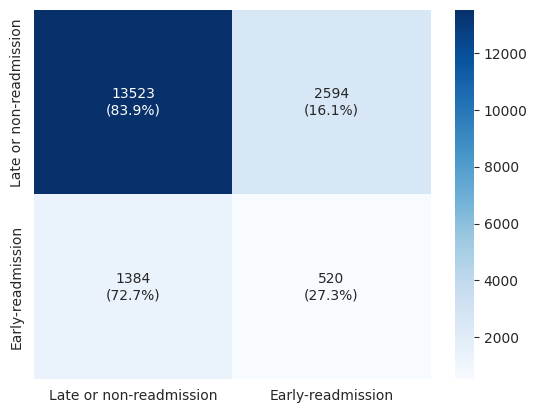

In [72]:
# Visualize confusion matrix with both absolute and percentage values
cm_smotetomek = confusion_matrix(y_test, y_test_pred_smotetomek)
cm_smotetomek_norm = confusion_matrix(y_test, y_test_pred_smotetomek, normalize='true')

annotations_smotetomek = np.array([
    [f"{val}\n({perc:.1%})" for val, perc in zip(row, norm_row)]
    for row, norm_row in zip(cm_smotetomek, cm_smotetomek_norm)
])

sns.heatmap(
    cm_smotetomek,
    annot=annotations_smotetomek,
    cmap='Blues',
    fmt='',
    xticklabels=['Late or non-readmission', 'Early-readmission'],
    yticklabels=['Late or non-readmission', 'Early-readmission']
)

## **6. Results Combined**
Visualizing all results obtained by different sampling methods, on the best respective models.

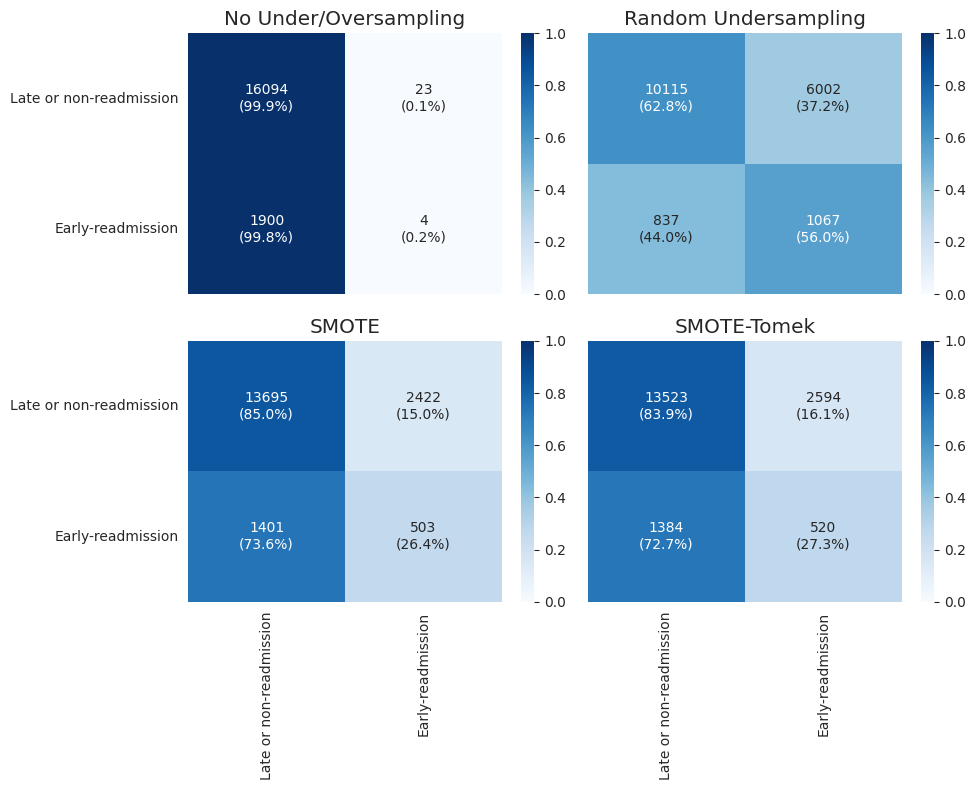

In [73]:
# Combine all confusion matrices into a single plot
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
cm_list = [cm_none_norm, cm_rus_norm, cm_smote_norm, cm_smotetomek_norm]
annotations = [annotations_none, annotations_rus, annotations_smote, annotations_smotetomek]
labels = ['No Under/Oversampling', 'Random Undersampling', 'SMOTE', 'SMOTE-Tomek']

# Define tick labels
xticklabels = ['Late or non-readmission', 'Early-readmission']
yticklabels = ['Late or non-readmission', 'Early-readmission']

for i, cm in enumerate(cm_list):
    ax=axs[i//2, i%2]
    sns.heatmap(
        cm,
        annot=annotations[i],
        cmap='Blues',
        fmt='',
        vmin=0, vmax=1,
        ax=axs[i//2, i%2],
        xticklabels=['Late or non-readmission', 'Early-readmission'],
        yticklabels=['Late or non-readmission', 'Early-readmission']
    )
    ax.set_title(labels[i])
    
    # Hide x-tick labels for the top row
    if i < 2:
        ax.set_xticklabels([])
    # Hide y-tick labels for the right column
    if i % 2 == 1:
        ax.set_yticklabels([])

plt.tight_layout()
plt.show()

Visualizing the scores for each method.

In [74]:
# Combine all metrics into a single DataFrame
data = {
    'Recall': [recall_none, recall_rus, recall_smote, recall_smotetomek],
    'Precision': [precision_none, precision_rus, precision_smote, precision_smotetomek],
    'F1-score': [f1_none, f1_rus, f1_smote, f1_smotetomek],
    'ROC-AUC': [roc_auc_none, roc_auc_rus, roc_auc_smote, roc_auc_smotetomek],
    'Accuracy': [accuracy_none, accuracy_rus, accuracy_smote, accuracy_smotetomek]
}

metrics_df = pd.DataFrame(data, index=labels)
metrics_df

,Recall,Precision,F1-score,ROC-AUC,Accuracy
No Under/Oversampling,0.500337,0.521279,0.473884,0.500337,0.893291
Random Undersampling,0.593999,0.537258,0.492587,0.593999,0.620498
SMOTE,0.556952,0.539580,0.542922,0.556952,0.787859
SMOTE-Tomek,0.556081,0.537073,0.539515,0.556081,0.779258
